<a href="https://colab.research.google.com/github/sunkusun9/movielens10k/blob/main/MovieLens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Movie Lens 100K을 통하여,

여러 가지 추천 모델을 적용해보고 성능을 비교해 본다.


#0.Import

In [2]:
import os, itertools, json
import pandas as pd
import numpy as np
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
import lightgbm as lgb


1.   Kaggle에서 MovieLens Dataset을 가져온다.
2.   그 다음 압축을 풀고 삭제한다.




# 1.데이터 다운로드 및 확인

In [3]:
if not os.path.isdir('ml-100k'):
  !wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
  !unzip ml-100k.zip
  !rm ml-100k.zip

--2022-01-11 07:50:18--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  15.4MB/s    in 0.3s    

2022-01-11 07:50:19 (15.4 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [4]:
os.listdir()

['.config', 'ml-100k', 'sample_data']

데이터에 기술된 README 파일을 들여다 본다

In [5]:
!cat ml-100k/README

SUMMARY & USAGE LICENSE

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under th

요약: 
* u.data: full dataset(943 users,  1682 items, 각각의 유저는 적어도 20번 이상 평가)
* u.info: 데이터수
* u.item: item에 대한 정보(item id, 타이틀, 출시일, 비디오 출시일\, IMdb URL| 장르...)
* u.genre: 장르 리스트 
* u.user: 사용자 정보(user id, 나이, 성별, 직업, 우편번호)
* u.occupation
* u(1~5).base test: 5-Fold Cross-validation 데이터셋

In [6]:
!ls -l ml-100k

total 15776
-rwxr-x--- 1 root root     716 Jul 19  2000 allbut.pl
-rwxr-x--- 1 root root     643 Jul 19  2000 mku.sh
-rw-r----- 1 root root    6750 Jan 29  2016 README
-rw-r----- 1 root root 1586544 Mar  8  2001 u1.base
-rw-r----- 1 root root  392629 Mar  8  2001 u1.test
-rw-r----- 1 root root 1583948 Mar  8  2001 u2.base
-rw-r----- 1 root root  395225 Mar  8  2001 u2.test
-rw-r----- 1 root root 1582546 Mar  8  2001 u3.base
-rw-r----- 1 root root  396627 Mar  8  2001 u3.test
-rw-r----- 1 root root 1581878 Mar  8  2001 u4.base
-rw-r----- 1 root root  397295 Mar  8  2001 u4.test
-rw-r----- 1 root root 1581776 Mar  8  2001 u5.base
-rw-r----- 1 root root  397397 Mar  8  2001 u5.test
-rw-r----- 1 root root 1792501 Mar  8  2001 ua.base
-rw-r----- 1 root root  186672 Mar  8  2001 ua.test
-rw-r----- 1 root root 1792476 Mar  8  2001 ub.base
-rw-r----- 1 root root  186697 Mar  8  2001 ub.test
-rw-r----- 1 root root 1979173 Jul 19  2000 u.data
-rw-r----- 1 root root     202 Jul 19  2000 u.genre
-

In [7]:
!cat ml-100k/mku.sh

#!/bin/sh

trap `rm -f tmp.$$; exit 1` 1 2 15

for i in 1 2 3 4 5
do
	head -`expr $i \* 20000` u.data | tail -20000 > tmp.$$
	sort -t"	" -k 1,1n -k 2,2n tmp.$$ > u$i.test
	head -`expr \( $i - 1 \) \* 20000` u.data > tmp.$$
	tail -`expr \( 5 - $i \) \* 20000` u.data >> tmp.$$
	sort -t"	" -k 1,1n -k 2,2n tmp.$$ > u$i.base
done

allbut.pl ua 1 10 100000 u.data
sort -t"	" -k 1,1n -k 2,2n ua.base > tmp.$$
mv tmp.$$ ua.base
sort -t"	" -k 1,1n -k 2,2n ua.test > tmp.$$
mv tmp.$$ ua.test

allbut.pl ub 11 20 100000 u.data
sort -t"	" -k 1,1n -k 2,2n ub.base > tmp.$$
mv tmp.$$ ub.base
sort -t"	" -k 1,1n -k 2,2n ub.test > tmp.$$
mv tmp.$$ ub.test



In [8]:
!cat ml-100k/allbut.pl

#!/usr/local/bin/perl

# get args
if (@ARGV < 3) {
	print STDERR "Usage: $0 base_name start stop max_test [ratings ...]\n";
	exit 1;
}
$basename = shift;
$start = shift;
$stop = shift;
$maxtest = shift;

# open files
open( TESTFILE, ">$basename.test" ) or die "Cannot open $basename.test for writing\n";
open( BASEFILE, ">$basename.base" ) or die "Cannot open $basename.base for writing\n";

# init variables
$testcnt = 0;

while (<>) {
	($user) = split;
	if (! defined $ratingcnt{$user}) {
		$ratingcnt{$user} = 0;
	}
	++$ratingcnt{$user};
	if (($testcnt < $maxtest || $maxtest <= 0)
	&& $ratingcnt{$user} >= $start && $ratingcnt{$user} <= $stop) {
		++$testcnt;
		print TESTFILE;
	}
	else {
		print BASEFILE;
	}
}


In [9]:
!cat ml-100k/u.info

943 users
1682 items
100000 ratings


In [10]:
#!cat ml-100k/u.item

|로 구분된 파일
디코딩에러가 나는 걸로 보아, 텍스트 형식이 utf-8이 아닌 것으로 보인다.
DataFrame으로 읽어 보자.

In [11]:
!cat ml-100k/u.genre

unknown|0
Action|1
Adventure|2
Animation|3
Children's|4
Comedy|5
Crime|6
Documentary|7
Drama|8
Fantasy|9
Film-Noir|10
Horror|11
Musical|12
Mystery|13
Romance|14
Sci-Fi|15
Thriller|16
War|17
Western|18



In [12]:
!head ml-100k/u.user

1|24|M|technician|85711
2|53|F|other|94043
3|23|M|writer|32067
4|24|M|technician|43537
5|33|F|other|15213
6|42|M|executive|98101
7|57|M|administrator|91344
8|36|M|administrator|05201
9|29|M|student|01002
10|53|M|lawyer|90703


In [13]:
!head ml-100k/u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013


# 2.데이터 로드 및 전처리

In [14]:
# 장르 리스트 로드
df_genre = pd.read_csv('ml-100k/u.genre', delimiter='|', encoding='latin-1', names=['genre', 'no'])
genre = list(df_genre['genre'])
# 직업 리스트 로드
df_occ = pd.read_csv('ml-100k/u.occupation', delimiter='|', encoding='latin-1', names=['occupation'])
occupation = list(df_occ['occupation'])

In [15]:
# 컬럼명, 'IMDb URL' 이후의 컬럼은 장르를 나타낸다
i_cols = ['item id', 'title' ,'release date','video release date', 'IMDb URL'] + genre
# 장르는 0 또는 1 이므로 타입은 int8로 하여 용량을 줄인다.
dtype = {i : np.int8 for i in genre}
# delimiter를 |fh encoding을 latin-1로 한다.
df_item = pd.read_csv('ml-100k/u.item', delimiter='|', encoding='latin-1', names=i_cols, index_col='item id', dtype=dtype)

In [16]:
# 처음 5개만 보자
df_item.head(5)

,title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
item id,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


장르를 복수로 지정로 지정이 돼있다.

In [17]:
df_item[~np.isnan(df_item['video release date'])]

,title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
item id,,,,,,,,,,,,,,,,,,,,,,,


In [18]:
df_item[df_item['release date'].isnull()]

,title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
item id,,,,,,,,,,,,,,,,,,,,,,,
267,unknown,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
#video release date이 있는 값은 없어 삭제한다.
df_item.drop(['video release date'], axis=1, inplace=True)

item_id가 267은  알 수 없는 item이다.

In [20]:
# release date의 타입을 str에서 datetime으로 변경
df_item.loc[~df_item['release date'].isnull(), 'release date'] = df_item[~df_item['release date'].isnull()]['release date'].map(lambda x:  datetime.strptime(x, '%d-%b-%Y'))
df_item['release date'] = df_item['release date'].astype(np.datetime64)

In [21]:
df_item.head(5)

,title,release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
item id,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),1995-01-01,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),1995-01-01,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),1995-01-01,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),1995-01-01,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [22]:
# 컬럼명
i_cols = ['user id', 'age' ,'gender','occupation', 'post']
# delimiter를 |fh encoding을 latin-1로 한다.
df_user = pd.read_csv('ml-100k/u.user', delimiter='|', encoding='latin-1', names=i_cols, index_col='user id')

In [23]:
# 처음 5개만 보자
df_user.head(5)

,age,gender,occupation,post
user id,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213


In [24]:
def read_data(filename):
  """
  평점 데이터 파일을 읽는다.
  Parameters
  ----------
  filename: str
    평점 파일명
  Returns
  -------
    pd.Dataframe
      평점 데이터프레임
  """
  df = pd.read_csv(filename, delimiter='\t', names=['user id', 'item id', 'rating', 'timestamp'])
  df['timestamp'] = df['timestamp'].map(lambda x: datetime.fromtimestamp(x))
  return df

In [25]:
df_data = read_data('ml-100k/u.data')

In [26]:
df_data.head(5)

,user id,item id,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


In [27]:
#평점 데이터에  item과 user 정보를 Join을 시킨다.
df_data = df_data.join(df_item, on='item id')
df_data = df_data.join(df_user, on='user id')

In [28]:
df_data.head(5)

,user id,item id,rating,timestamp,title,release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,post
0,196,242,3,1997-12-04 15:55:49,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,49,M,writer,55105
1,186,302,3,1998-04-04 19:22:22,L.A. Confidential (1997),1997-01-01,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,39,F,executive,00000
2,22,377,1,1997-11-07 07:18:36,Heavyweights (1994),1994-01-01,http://us.imdb.com/M/title-exact?Heavyweights%...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,25,M,writer,40206
3,244,51,2,1997-11-27 05:02:03,Legends of the Fall (1994),1994-01-01,http://us.imdb.com/M/title-exact?Legends%20of%...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,28,M,technician,80525
4,166,346,1,1998-02-02 05:33:16,Jackie Brown (1997),1997-01-01,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,47,M,educator,55113


In [29]:
# 시청했을 때와 영화 출시로 부터 경과한 시점을 계산한다.
df_data['date_diff'] = (df_data['timestamp'] - df_data['release date'])
df_data['date_diff'] = df_data['date_diff'].map(lambda x: x.days)

#3.Descriptive Analysis

In [30]:
df_item.isnull().sum()

title           0
release date    1
IMDb URL        3
unknown         0
Action          0
Adventure       0
Animation       0
Children's      0
Comedy          0
Crime           0
Documentary     0
Drama           0
Fantasy         0
Film-Noir       0
Horror          0
Musical         0
Mystery         0
Romance         0
Sci-Fi          0
Thriller        0
War             0
Western         0
dtype: int64

item id 267번을 제외하고 IMDb URL이 결측있는 것 2 건 
iMDb 주소로는 현재 유효하지 않아 상관하지 않는 다.

In [31]:
df_user.isnull().sum()

age           0
gender        0
occupation    0
post          0
dtype: int64

사용자 정보에는 결측치가 없다.

In [32]:
df_data.isnull().sum()

user id          0
item id          0
rating           0
timestamp        0
title            0
release date     9
IMDb URL        13
unknown          0
Action           0
Adventure        0
Animation        0
Children's       0
Comedy           0
Crime            0
Documentary      0
Drama            0
Fantasy          0
Film-Noir        0
Horror           0
Musical          0
Mystery          0
Romance          0
Sci-Fi           0
Thriller         0
War              0
Western          0
age              0
gender           0
occupation       0
post             0
date_diff        9
dtype: int64

평점 데이터에도 결측치가 없다. 하지만 item id가 267인 것 자체가 영화를 알 수 없다는 것이므로 item_id가 267인 걸 살펴보자.

In [33]:
df_data.loc[df_data['item id'] == 267], len(df_data.loc[df_data['item id'] == 267])

(       user id  item id  rating  ...     occupation   post date_diff
 2172       130      267       5  ...           none  60115       NaN
 3781         5      267       4  ...          other  15213       NaN
 7245       268      267       3  ...       engineer  19422       NaN
 12475      297      267       3  ...       educator  98103       NaN
 14756      319      267       4  ...     programmer  22030       NaN
 15292        1      267       4  ...     technician  85711       NaN
 49295      532      267       3  ...        student  92705       NaN
 93523      833      267       1  ...         writer  90019       NaN
 99723      422      267       4  ...  entertainment  94533       NaN
 
 [9 rows x 31 columns], 9)

9건이 unknown 영화이다.

In [34]:
df_user['post'].unique()

array(['85711', '94043', '32067', '43537', '15213', '98101', '91344',
       '05201', '01002', '90703', '30329', '06405', '29206', '55106',
       '97301', '10309', '06355', '37212', '02138', '95660', '30068',
       '40206', '48197', '94533', '55107', '21044', '30030', '55369',
       '55436', '10003', '78741', '27510', '42141', '42459', '93117',
       '55105', '54467', '01040', '27514', '80525', '17870', '20854',
       '46260', '50233', '46538', '07102', '12550', '76111', '52245',
       '16509', '55414', '66315', '01331', '84010', '52246', '08403',
       '06472', '30040', '97214', '75240', '43202', '48118', '80521',
       '60402', '22904', '55337', '60067', '98034', '73034', '41850',
       'T8H1N', '08816', '02215', '29379', '61801', '03755', '52241',
       '21218', '22902', '44133', '20003', '46005', '89503', '11701',
       '68106', '78155', '01913', '23112', '71457', '10707', '75206',
       '98006', '90291', '63129', '90254', '05146', '30220', '55108',
       '55125', '604

In [35]:
df_user['post1'] = df_user['post'].map(lambda x: x[0] if x[0] >= '0' and x[0] <= '9'  else 'etc')

In [36]:
post1_code = ['{}'.format(i) for i in range(10)] + ['etc']

In [37]:
df_user.groupby(['post1'])['post1'].count()

post1
0       96
1       97
2      101
3       62
4       77
5      121
6       78
7       67
8       56
9      170
etc     18
Name: post1, dtype: int64

In [38]:
df_data['post1'] = df_data['post'].map(lambda x: x[0] if x[0] >= '0' and x[0] <= '9'  else 'etc')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


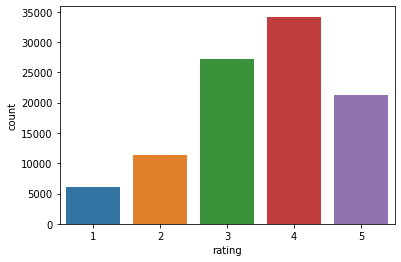

In [39]:
# 평점수
sns.countplot(df_data['rating'])

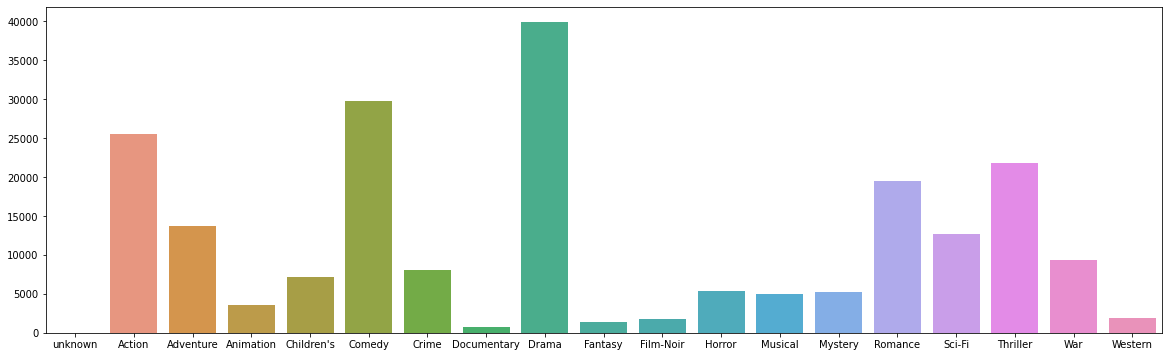

In [40]:
# 장르 별 시청 수
fig, ax = plt.subplots(figsize=(20, 6))
genre_sum = df_data[genre].sum()
sns.barplot(x=genre_sum.index, y=genre_sum.values, ax=ax)
plt.show()

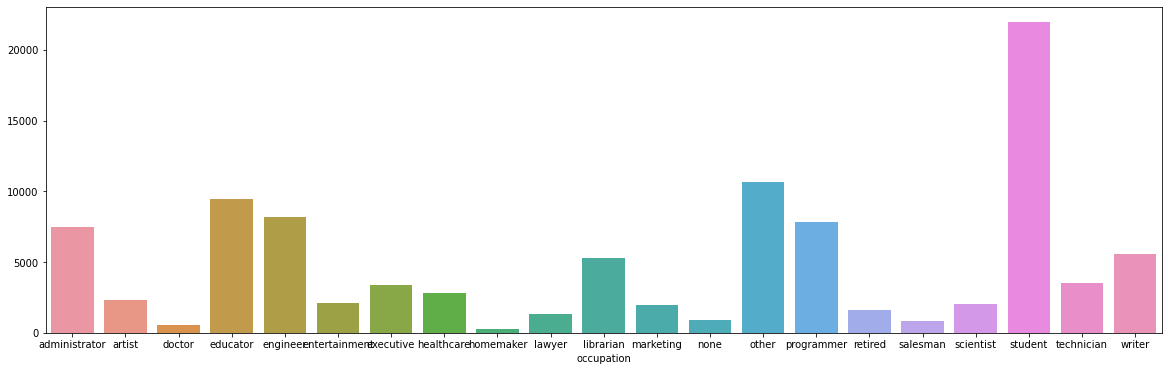

In [41]:
# 시청한 사람들의 직업 분포
fig, ax = plt.subplots(figsize=(20, 6))
occupation_sum = df_data.groupby('occupation')['user id'].count()
sns.barplot(x=occupation_sum.index, y=occupation_sum.values, ax=ax)
plt.show()

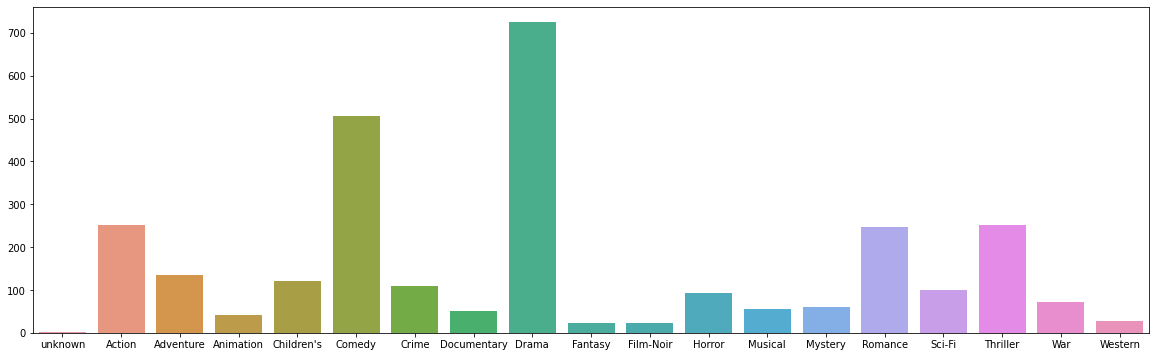

In [42]:
# 영화 목록에서의 장르수
fig, ax = plt.subplots(figsize=(20, 6))
genre_sum = df_item[genre].sum()
sns.barplot(x=genre_sum.index, y=genre_sum.values, ax=ax)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


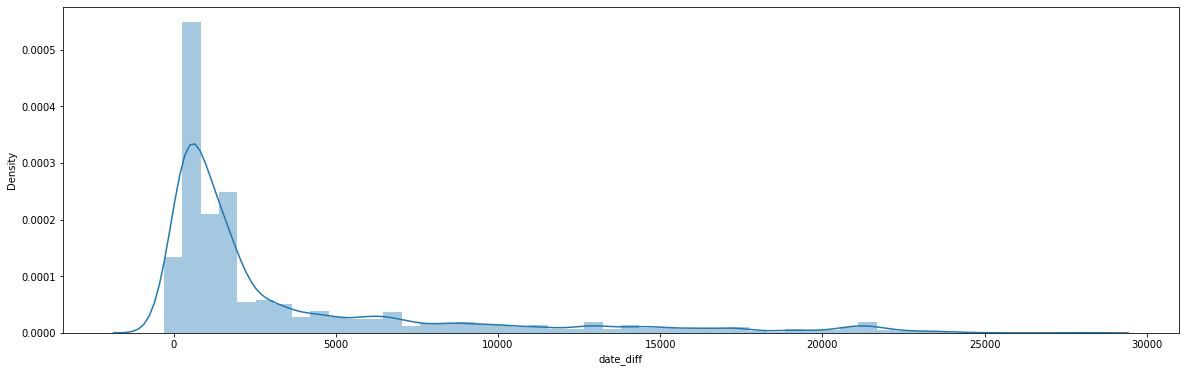

In [43]:
# 영화의 출시일 부터 시청시 경과 시점의 분포 확인
fig, ax = plt.subplots(figsize=(20, 6))
sns.distplot(df_data['date_diff'], ax=ax)
plt.show()

음수가 있는 걸로 보아 출시 이전에 데이터도 존재하고 있고, 출시후 2500 일이 경과 한 영화의 비율까지 많이 있다. 이 이후에 도 건수가 고루 존재함을 알수 잇다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


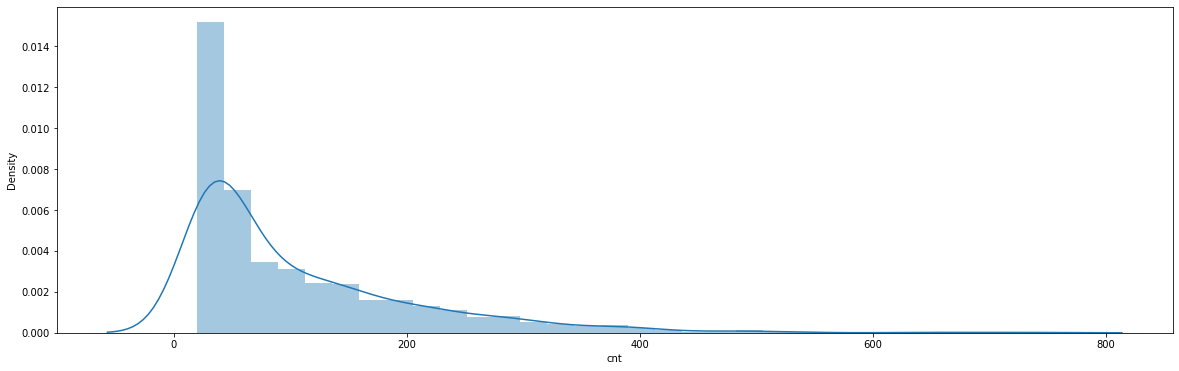

In [44]:
df_user_rating_cnt = df_data.groupby(['user id'], as_index=False)['item id'].count()
df_user_rating_cnt.columns = ['user id', 'cnt']
fig, ax = plt.subplots(figsize=(20, 6))
sns.distplot(df_user_rating_cnt['cnt'], ax=ax)
plt.show()

설명대로 최소 20건 했다, 최대  800건까지  했고, 급격하게 줄어드는 추세를 보인다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


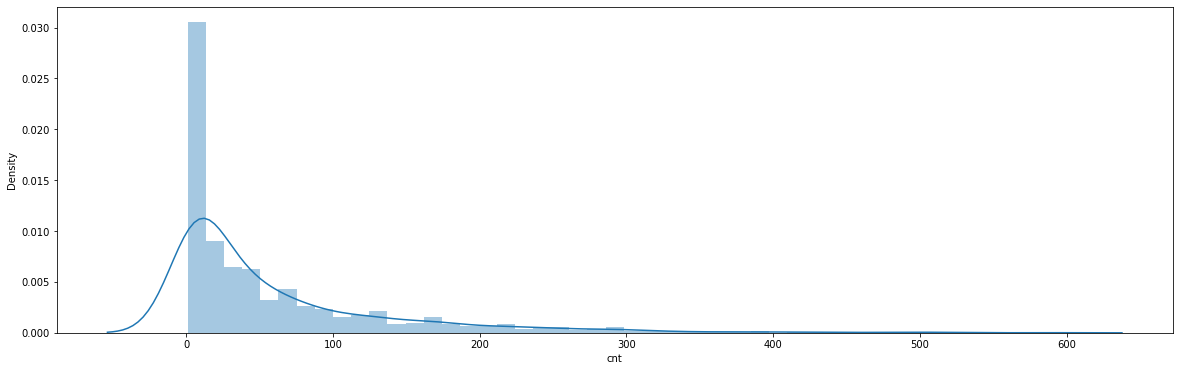

In [45]:
df_item_rating_cnt = df_data.groupby(['item id'], as_index=False)['user id'].count()
df_item_rating_cnt.columns = ['item id', 'cnt']
fig, ax = plt.subplots(figsize=(20, 6))
sns.distplot(df_item_rating_cnt['cnt'], ax=ax)
plt.show()

1건만 있는 사례로 존재하고 최대 평점이 600건 존재하는 것도 있지만 대부분 100건 아래이고 역시 건수가 갈수 록 줄어 든다.

In [46]:
df_data['view date'] = df_data['timestamp'].map(lambda x: x.date())
df_date_cnt = df_data.groupby('view date')['timestamp'].count()

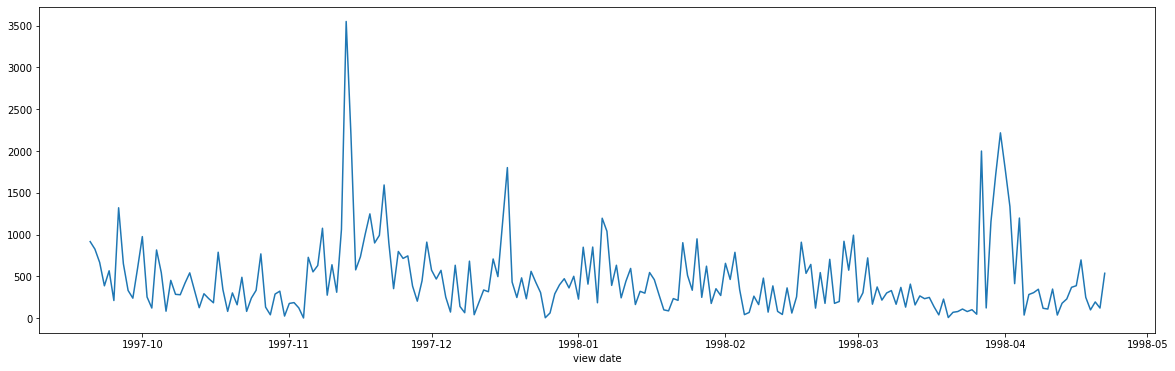

In [47]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.lineplot(x = df_date_cnt.index,  y = df_date_cnt.values, ax=ax)
plt.show()

1997년 9월 ~ 1998년  5월, 6개월간 데이터

#4.Exploratory Data Analysis

In [48]:
df_data['rating'].std(), df_data.groupby('item id')['rating'].std().mean(), df_data.groupby('user id')['rating'].std().mean()

(1.125673599144129, 1.0567144528273058, 1.0198826977076085)

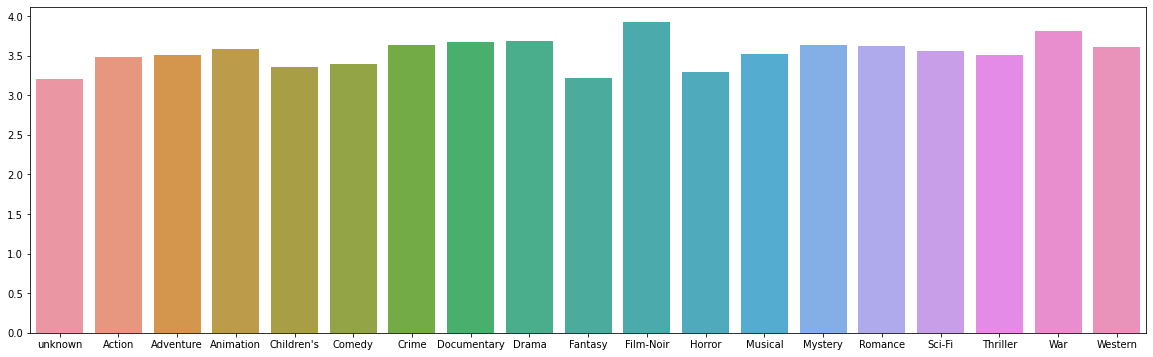

In [49]:
# 장르별 평균 평점
fig, ax = plt.subplots(figsize=(20, 6))
genre_avg_rating = []
genre_sum = df_data[genre].sum()
for i in genre:
  genre_avg_rating.append(np.sum(df_data[i] * df_data['rating']) / genre_sum[i])
sns.barplot(x=genre, y=genre_avg_rating, ax=ax)
plt.show()

In [50]:
np.std(genre_avg_rating)

0.18332764937940538

In [51]:
df_data_genre = pd.melt(df_data, id_vars=['user id', 'rating'], value_vars=genre)
df_data_genre = df_data_genre.loc[df_data_genre['value'] > 0]
# 사용자 별 장르별 편차의 평균 구해 보자
df_data_genre.groupby(['user id', 'variable'], as_index=False)['rating'].mean().groupby('user id').std().mean()

rating    0.555182
dtype: float64

사용자별 장르별 편차의 평균이 0.55이다. 전체적으로 편차가 0.183인데 개인별 편차가 0.55를 보인다는 것은 개인별로 장르에 대한 선호도가 명확이 드러남을  알 수 있다.

In [52]:
df_data_genre = pd.melt(df_data, id_vars=['occupation', 'rating'], value_vars=genre)
df_data_genre = df_data_genre.loc[df_data_genre['value'] > 0]
df_data_genre = df_data_genre.loc[df_data_genre['variable'] != 'unknown']
df_occupation = df_data_genre.groupby(['occupation', 'variable'], as_index=False)['rating'].mean()
df_occupation.columns =['occupation', 'genre', 'rating']

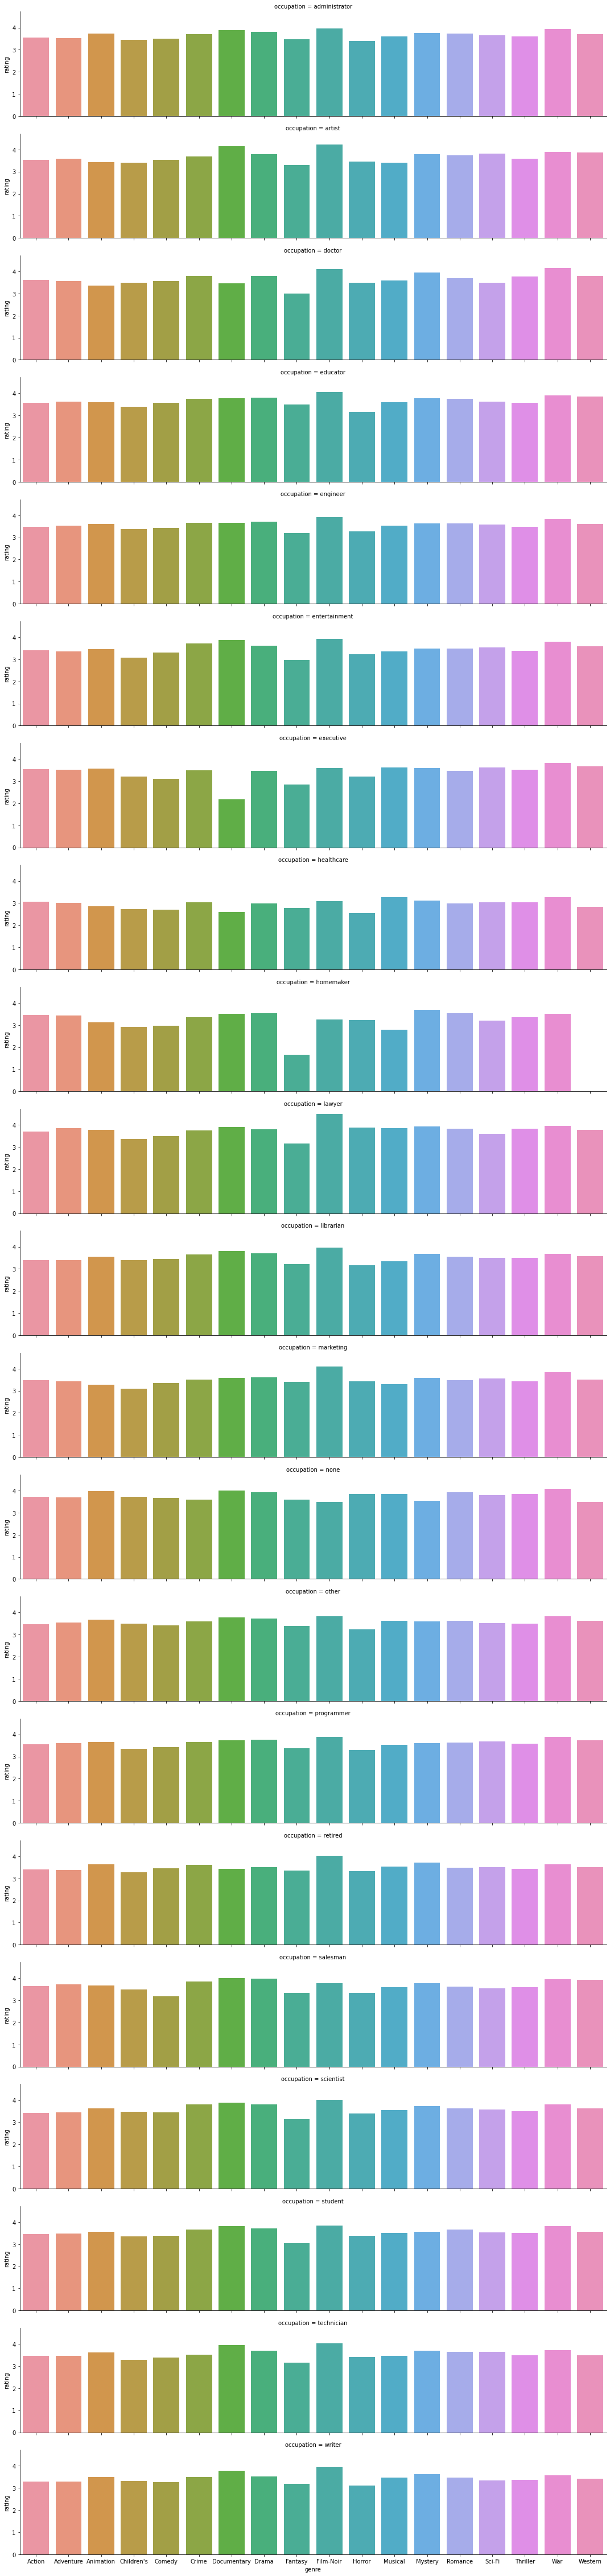

In [53]:
sns.catplot(x='genre', y='rating', col="occupation", kind='bar', col_wrap=1, data=df_occupation, aspect=5, height=3)

직업에 따른 장르에 대한 편차가 약간씩 보인다. 직업별로 장르에 대한 선호와 연관있음을 알 수 있다.

In [54]:
df_data['aged'] = np.digitize(df_data['age'], [10, 20, 30, 40, 50, 60, 70])
df_data_genre = pd.melt(df_data, id_vars=['aged', 'rating'], value_vars=genre)
df_data_genre = df_data_genre.loc[df_data_genre['value'] > 0]
df_data_genre = df_data_genre.loc[df_data_genre['variable'] != 'unknown']
df_aged = df_data_genre.groupby(['aged', 'variable'], as_index=False)['rating'].mean()
df_aged.columns =['aged', 'genre', 'rating']

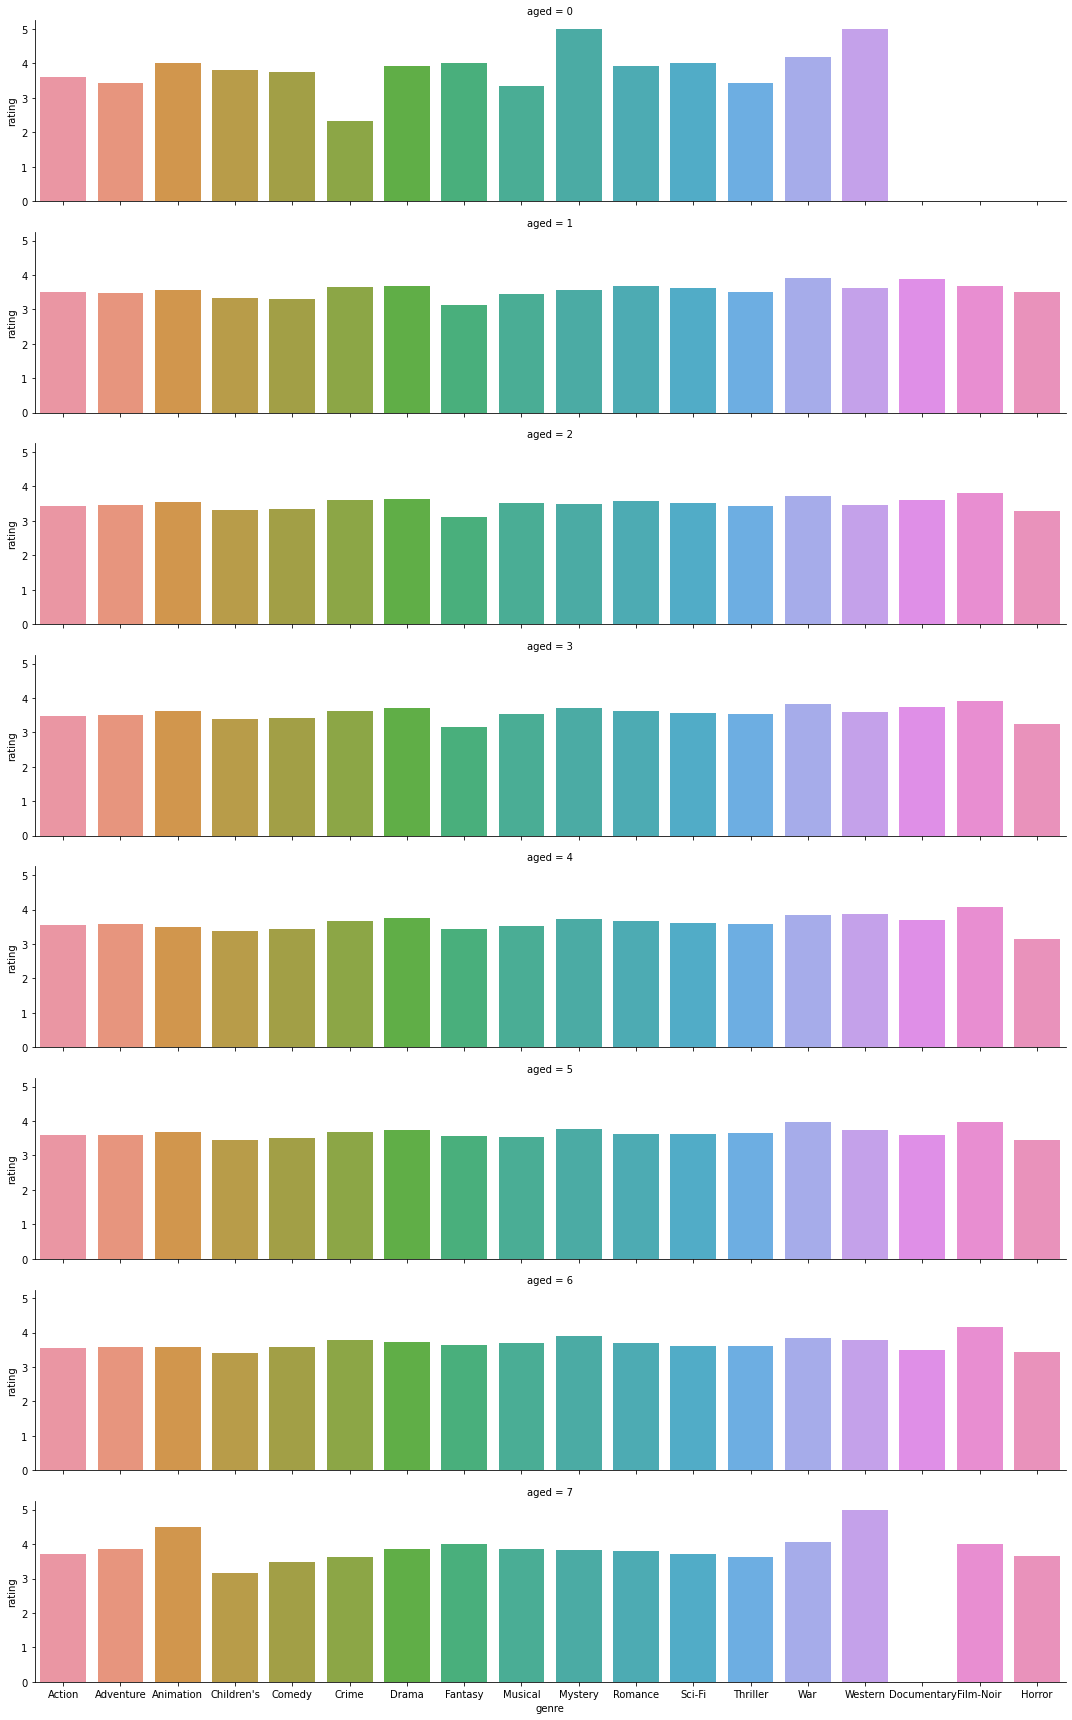

In [55]:
sns.catplot(x='genre', y='rating', col="aged", kind='bar', col_wrap=1, data=df_aged, aspect=5, height=3)

연령에 따라서도 장르에 대한 선호도가 미세하게 나마 차이나는 것을 알 수 있다.

In [56]:
df_data_genre = pd.melt(df_data, id_vars=['post1', 'rating'], value_vars=genre)
df_data_genre = df_data_genre.loc[df_data_genre['value'] > 0]
df_data_genre = df_data_genre.loc[df_data_genre['variable'] != 'unknown']
df_post1 = df_data_genre.groupby(['post1', 'variable'], as_index=False)['rating'].mean()
df_post1.columns =['post1', 'genre', 'rating']

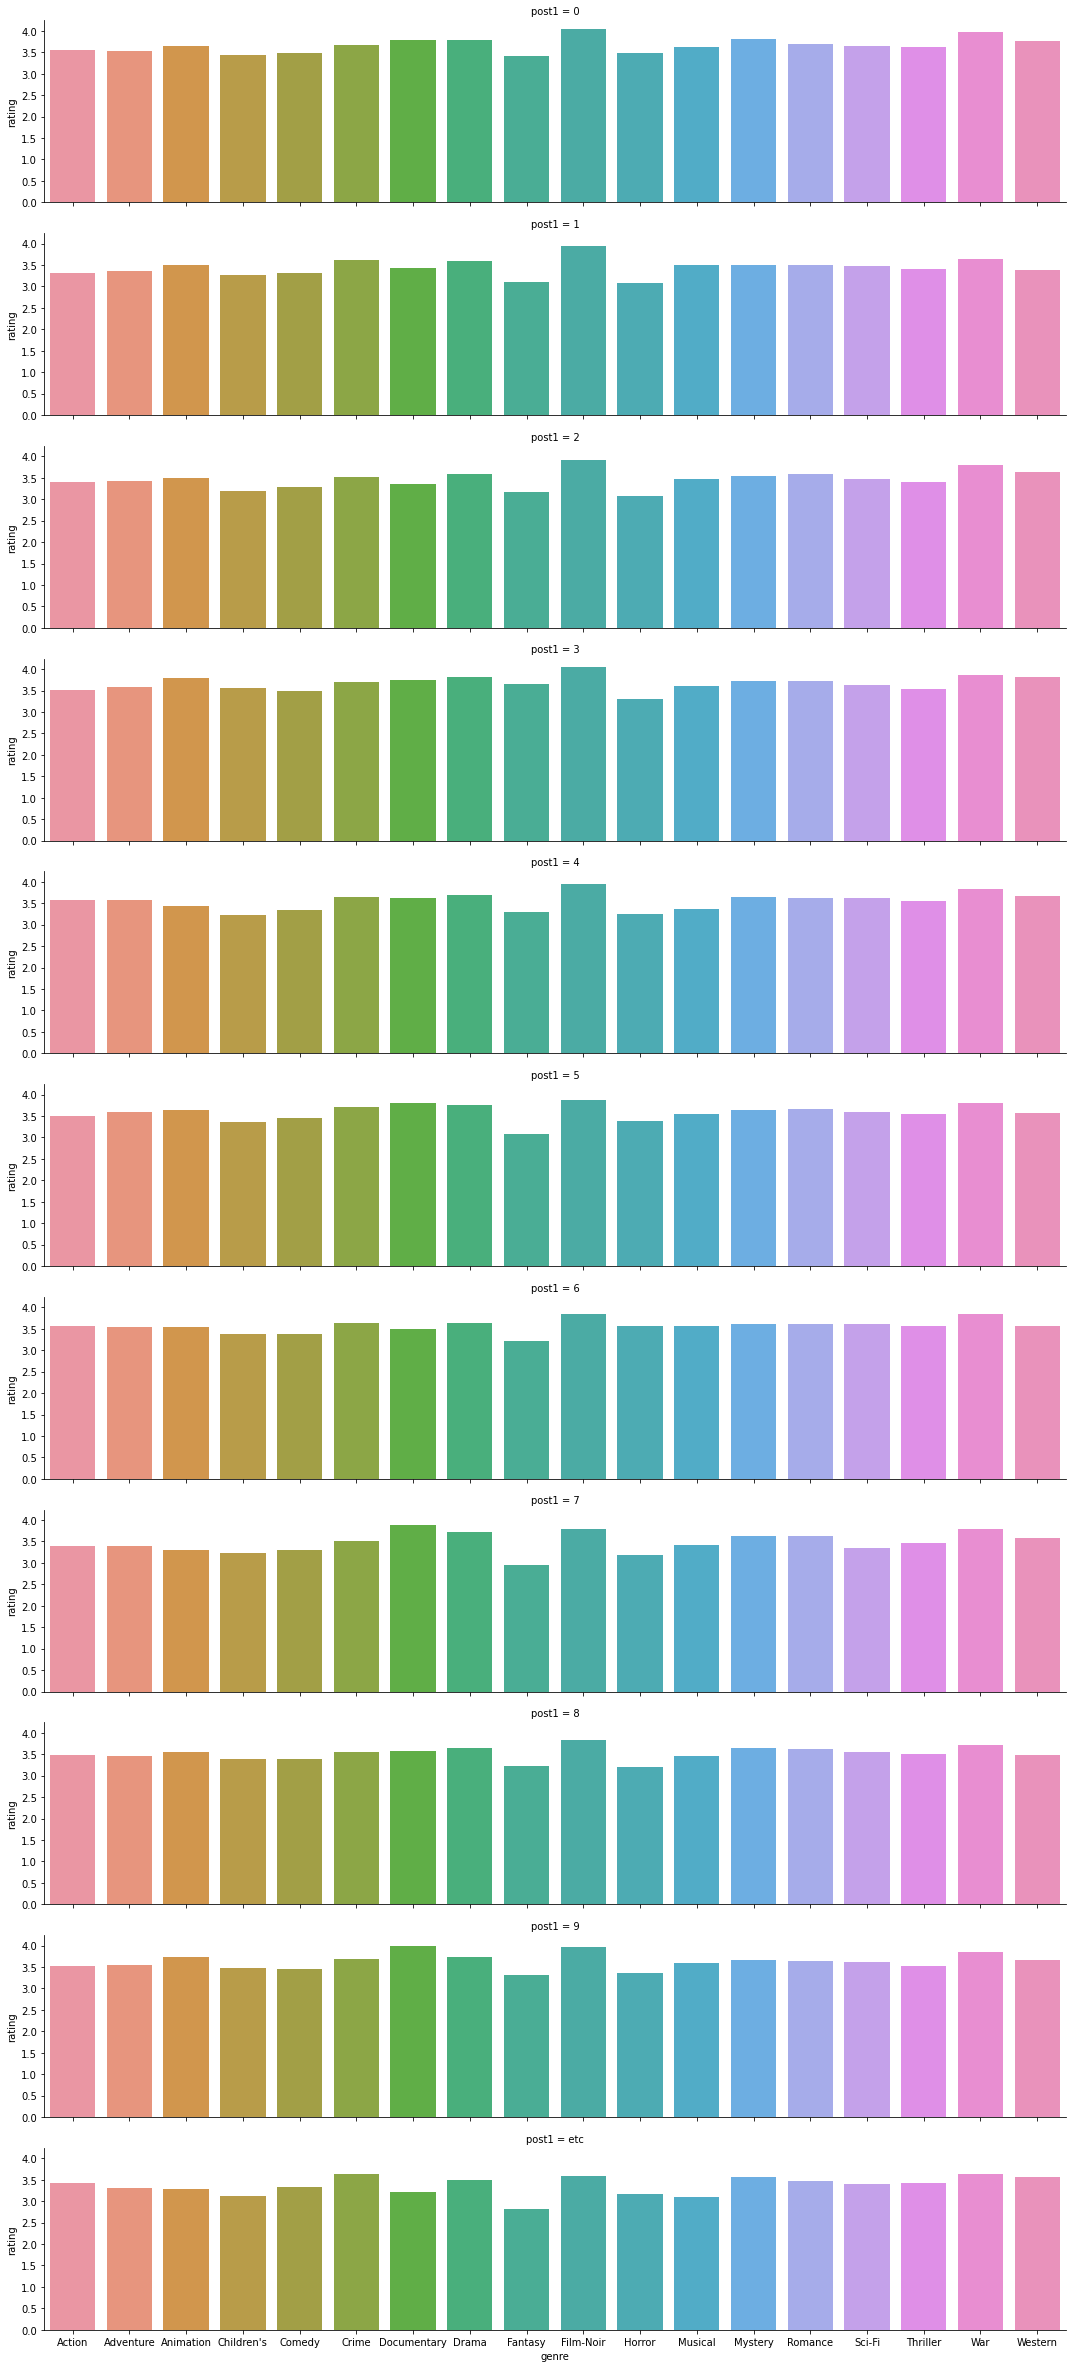

In [57]:
sns.catplot(x='genre', y='rating', col="post1", kind='bar', col_wrap=1, data=df_post1, aspect=5, height=3)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


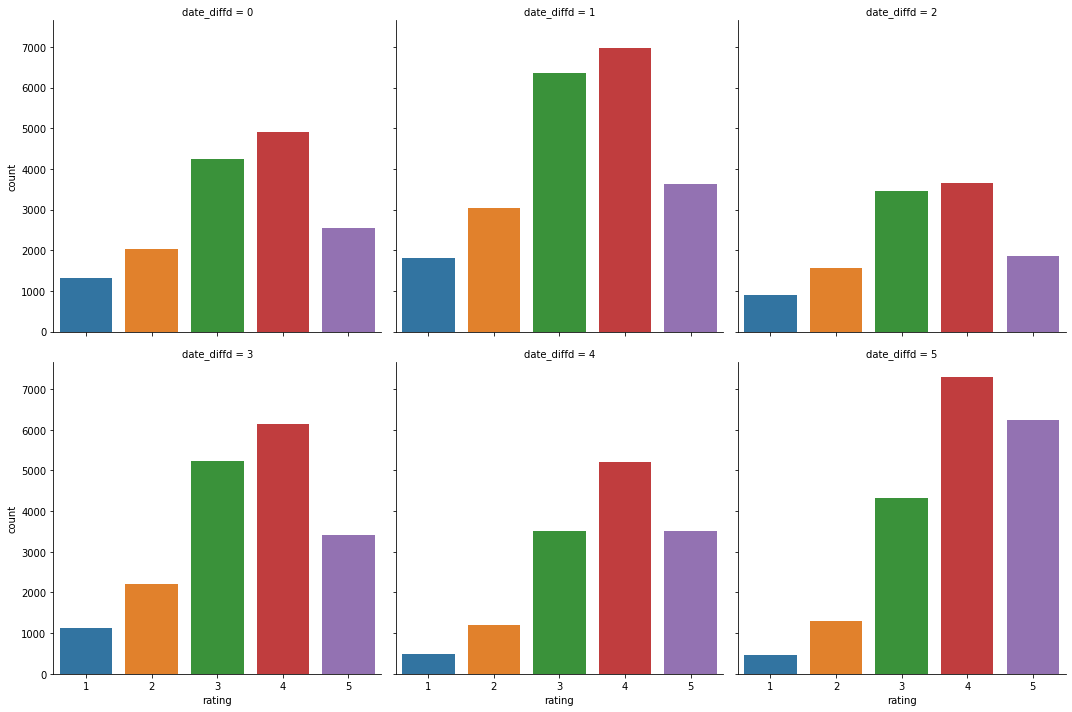

In [58]:
df_data['date_diffd'] = np.digitize(df_data['date_diff'], [365, 720, 1200, 2400, 6000])
sns.catplot('rating', col="date_diffd", col_wrap=3, kind='count', data=df_data.loc[~np.isnan(df_data['date_diff'])])

오래된 콘텐츠 일수록 높은 평점의 분포가 높아지고 있다. 하지만 그 경향이 뚜렷하지는 않다.

#5.Feature Processing

Item, User의 점수에 대한 평균

In [59]:
df_user_avg = df_data.groupby(['user id'])['rating'].agg(['sum', 'count'])
df_user_avg.columns = ['user_rating_mean', 'user_rating_count']
df_item_avg = df_data.groupby(['item id'])['rating'].agg(['sum', 'count'])
df_item_avg.columns = ['item_rating_mean', 'item_rating_count']

In [60]:
df_data = df_data.join(df_user_avg, on='user id')
df_data = df_data.join(df_item_avg, on='item id')
df_data['user_rating_mean'] = (df_data['user_rating_mean'] - df_data['rating']) / (df_data['user_rating_count'] - 1 + 1e-8)
df_data['item_rating_mean'] = (df_data['item_rating_mean'] - df_data['rating']) / (df_data['item_rating_count'] - 1 + 1e-8)

In [61]:
df_data['aged'] = np.digitize(df_data['age'], [10, 20, 30, 40, 50, 60, 70])
df_data['date_diffd'] = np.digitize(df_data['date_diff'], [365, 720, 1200, 2400, 6000])

In [62]:
occ_cols = []
for i in df_data['occupation'].unique():
  df_data['is_occupation_{}'.format(i)] = df_data['occupation'] == i
  occ_cols.append('is_occupation_{}'.format(i))

aged_cols = []
for i in df_data['aged'].unique():
  df_data['is_aged_{}'.format(i)] = df_data['aged'] == i
  aged_cols.append('is_aged_{}'.format(i))

date_diffd_cols = []
for i in df_data['date_diffd'].unique():
  df_data['is_date_diffd_{}'.format(i)] = df_data['date_diffd'] == i
  date_diffd_cols.append('is_date_diffd_{}'.format(i))

for i in post1_code:
  df_data['is_post1_{}'.format(i)] = df_data['post1'] == i
  date_diffd_cols.append('is_post1_{}'.format(i))

In [63]:
df_corr = df_data[['rating', 'user_rating_mean', 'item_rating_mean'] + genre + occ_cols + aged_cols + date_diffd_cols].corr()

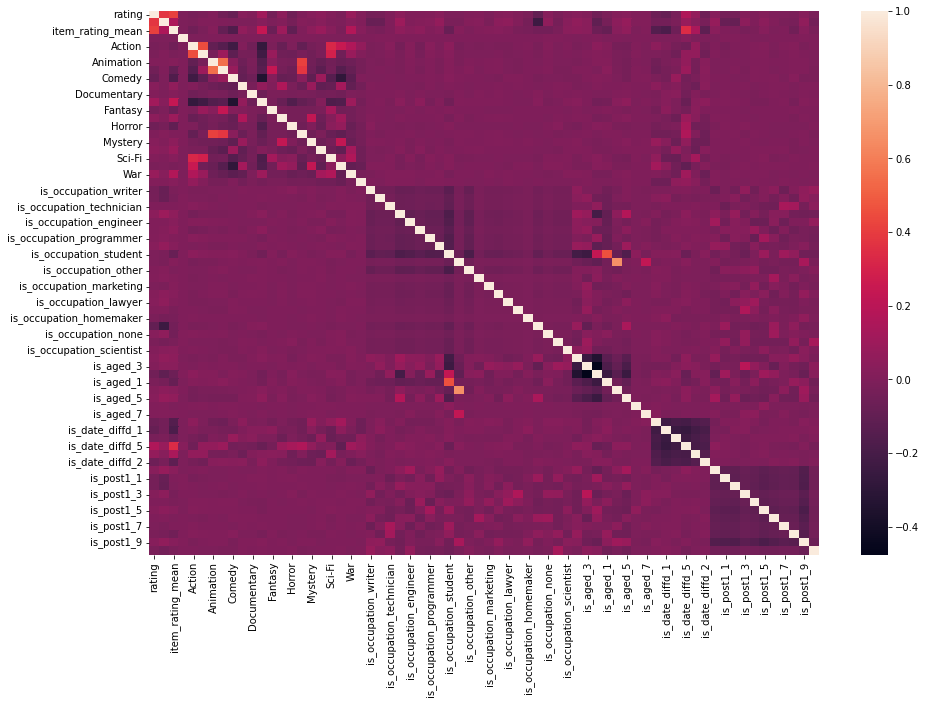

In [64]:
# 0.0에 가까울 수록 관계가 없다.
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_corr, ax = ax)

Item별 평균, User 평균이 가장 높은 연관성을 보였고, 

나머지 속성은  미묘하게 연관성을 보인다.

#6.Common Data Processing

이전 분석 과정에서 나온 사항을 반영한

이 후 Chapter에서 사용할 데이터 처리 및 함수 정의

In [65]:
# 장르 리스트를 로드
df_genre = pd.read_csv('ml-100k/u.genre', delimiter='|', encoding='latin-', names=['genre', 'no'])
# 직업 리스트를 로드
df_occ = pd.read_csv('ml-100k/u.occupation', delimiter='|', encoding='latin-', names=['occupation'])
genre = list(df_genre['genre'])
occupation = list(df_occ['occupation'])
del df_genre, df_occ
# 컬럼명, 'IMDb URL' 이후의 컬럼은 장르를 나타낸다
i_cols = ['item id', 'title' ,'release date','video release date', 'IMDb URL'] + genre
# 장르는 0 또는 1 이므로 타입은 int8로 하여 용량을 줄인다.
dtype = {i : np.int8 for i in genre}
# delimiter를 |fh encoding을 latin-1로 한다.
df_item = pd.read_csv('ml-100k/u.item', delimiter='|', encoding='latin-1', names=i_cols, index_col='item id', dtype=dtype)
#video release date이 있는 값은 없어 삭제한다.
df_item.drop(['video release date'], axis=1, inplace=True)
# release date의 타입을 str에서 datetime으로 변경
df_item.loc[~df_item['release date'].isnull(), 'release date'] = df_item[~df_item['release date'].isnull()]['release date'].map(lambda x:  datetime.strptime(x, '%d-%b-%Y'))
df_item['release date'] = df_item['release date'].astype(np.datetime64)
# 컬럼명
i_cols = ['user id', 'age' ,'gender','occupation', 'post']
# delimiter를 |fh encoding을 latin-1로 한다.
df_user = pd.read_csv('ml-100k/u.user', delimiter='|', encoding='latin-1', names=i_cols, index_col='user id')
df_user['aged'] = np.digitize(df_user['age'], [10, 20, 30, 40, 50, 60, 70])
# Linear Regression, Neural Network, Matrix Factorization을 위한 categorical feature, binning feature(item_rating_countd, user_rating_countd)에 대한 one-hot value column
occ_cols = ['is_occupation_{}'.format(i) for i in occupation]
aged_cols = ['is_aged_{}'.format(i) for i in range(8)]
for i in range(8):
  df_user['is_aged_{}'.format(i)] = (df_user['aged'] == i).astype(np.int8)
for i in occupation:
  df_user['is_occupation_{}'.format(i)] = (df_user['occupation'] == i).astype(np.int8)
post1_code = ['{}'.format(i) for i in range(10)] + ['etc']
df_user['post1'] = df_user['post'].map(lambda x: x[0] if x[0] >= '0' and x[0] <= '9'  else 'etc')
for i in post1_code:
  df_user['is_post1_{}'.format(i)] = (df_user['post1'] == i).astype(np.int8)
date_diffd_cols = ['is_date_diffd_{}'.format(i) for i in range(6)]
item_rating_countd_cols = ['item_rating_countd_{}'.format(i) for i in range(6)]
user_rating_countd_cols = ['user_rating_countd_{}'.format(i) for i in range(6)]
post1_cols = ['is_post1_{}'.format(i) for i in post1_code]

In [66]:
def read_raw_data(filename):
  """
  원본 평점데이터를 읽어들이고, 
  평점데이터에서만 처리할 수 있는 전처리 작업 수행
  Parameters
  ----------
  filename - str
    파일명
  Returns
  -------
    pd.Dataframe
      데이터프레임
  """
  df = pd.read_csv(filename, delimiter='\t', names=['user id', 'item id', 'rating', 'timestamp'])
  df['timestamp'] = df['timestamp'].map(lambda x: datetime.fromtimestamp(x))
  # 시청했을 때와 영화 출시로 부터 경과한 시점을 계산해
  df = df.join(df_item, on='item id')
  df = df.join(df_user, on='user id')
  df['date_diff'] = df['timestamp'] - df['release date']
  df['date_diff'] = df['date_diff'].map(lambda x: x.days)
  df['date_diffd'] = np.digitize(df['date_diff'], [365, 720, 1200, 2400, 6000])
  for i in range(6):
    df['is_date_diffd_{}'.format(i)] = (df['date_diffd'] == i).astype(np.int8)
  return df

In [67]:
def read_dataset(set_no):
  """
  원본 데이터를 읽어들이고, 
  item데이터와 user데이터를 join 하고 
  이에 대한 후처리 작업 수행
  Parameters
  ----------
    set_no: int
      dataset 번호
  Returns
  -------
    pd.Dataframe
      데이터프레임
  """
  df_base = read_raw_data('ml-100k/u{}.base'.format(set_no))
  # 사용자의 평점 평균을 구하기 위한 합, 카운트 구한다
  df_user_avg = df_base.groupby(['user id'])['rating'].agg(['sum', 'count'])
  df_user_avg.columns = ['user_rating_mean', 'user_rating_count']
  # 아이템의 평점 평균을 구하기 위한 합, 카운트 구한다
  df_item_avg = df_base.groupby(['item id'])['rating'].agg(['sum', 'count'])
  df_item_avg.columns = ['item_rating_mean', 'item_rating_count']
  # 평점데이터에 통계 정보 join
  df_base = df_base.join(df_user_avg, on='user id')
  df_base = df_base.join(df_item_avg, on='item id')
  # 평점 항목의 사항을 제외: 통계 정보에 학습시 예측하고자하는 사항에 예측 내용이 반영 되는 것을 피하여, 통계의 정합성을 높힌다.
  df_base['user_rating_count'] = df_base['user_rating_count'] - 1
  df_base['item_rating_count'] = df_base['item_rating_count'] - 1
  df_base['user_rating_mean'] = (df_base['user_rating_mean'] - df_base['rating']) / (df_base['user_rating_count'] + 1e-8)
  df_base['item_rating_mean'] = (df_base['item_rating_mean'] - df_base['rating']) / (df_base['item_rating_count'] + 1e-8)
  # 카운트를 구간화 한다.
  df_base['user_rating_countd'] = np.digitize(df_base['user_rating_count'] - 1, [30, 50, 100, 200, 500])
  df_base['item_rating_countd'] = np.digitize(df_base['item_rating_count'] - 1, [1, 10, 50, 100, 300])

  df_test = read_raw_data('ml-100k/u{}.test'.format(set_no))
  df_test = df_test.join(df_user_avg, on='user id')
  df_test = df_test.join(df_item_avg, on='item id')
  # 테스트 항목에서는 통계의 테스트 데이터가 반영이 된 상태는 아니므로 항목의 평점을 제외할 필요는 없고, 통계가 없는 항목에 대해 0을 넣어준다.
  df_test['user_rating_mean'] = df_test['user_rating_mean'].fillna(0) / (df_test['user_rating_count'].fillna(0) + 1e-8)
  df_test['item_rating_mean'] = df_test['item_rating_mean'].fillna(0) / (df_test['item_rating_count'].fillna(0) + 1e-8)
  df_test['user_rating_countd'] = np.digitize(df_test['user_rating_count'], [30, 50, 100, 200, 500])
  df_test['item_rating_countd'] = np.digitize(df_test['item_rating_count'], [1, 10, 50, 100, 300])
  # 구간화한 카운트 정보에 대하여 one-hot value로 나타낸다. (Linear Regression, Neural Network, Matrix factorization 등의 모델에서 사용)
  for i in range(6):
    df_base['user_rating_countd_{}'.format(i)] = (df_base['user_rating_countd'] == i).astype(np.int8)
    df_base['item_rating_countd_{}'.format(i)] = (df_base['item_rating_countd'] == i).astype(np.int8)
    df_test['user_rating_countd_{}'.format(i)] = (df_test['user_rating_countd'] == i).astype(np.int8)
    df_test['item_rating_countd_{}'.format(i)] = (df_test['item_rating_countd'] == i).astype(np.int8)
  return df_base, df_test

#7.Matrix Factorization 소개

Matrix Factorization에 대한 소개이고, 

다양한 예측 모델을 사용한 예측 작업은 8장에서 다룬다.

##1.통계기반 예측

Item,user의 평균 값으로만 예측을 해보자.

In [68]:
df_base, df_test = read_dataset(1)

In [69]:
# 테스트 Item의 평균으로 예측 했을 때 MSE, user의 평균으로 예측했을때 MSE
np.mean(np.square(df_base['item_rating_mean'] - df_base['rating'])), np.mean(np.square(df_base['user_rating_mean'] - df_base['rating']))
# 사용자별 평균으로만으로 예측했을 때, 검증셋에 대한 MSE가 1.076 정도는 나온다

(1.0522663057403405, 1.0764250024743085)

In [70]:
# 테스트 데이터를 Item의 평균으로 예측 했을 때 MSE, user의 평균으로 예측했을때 MSE
np.mean(np.square(df_test['item_rating_mean'] - df_test['rating'])), np.mean(np.square(df_test['user_rating_mean'] - df_test['rating']))
# 아이템별 평균으로만으로 예측했을 때, MSE가 1.129 정도는 나온다

(1.0734243764895939, 1.1299586414166156)

In [71]:
tf.random.set_seed(1)
# item의 평균과, user의 평균으로 Linear regression(선형회귀분석)을 할 떄
input = tf.keras.layers.Input(shape = (2), name='inp')
# Hidden Unit이 없고 Dense Layer Unit이 1 이면 곧 Linear Regression이 된다.
prd = tf.keras.layers.Dense(1)(input)
model = tf.keras.models.Model(inputs=input, outputs=prd)
model.compile('Adam', tf.keras.losses.mean_squared_error)
# df_base로 모델을 학습시키고, df_test로 검증한다.
hist_stat = model.fit(x=df_base[['item_rating_mean', 'user_rating_mean']], y=df_base['rating'], 
          validation_data=(df_test[['item_rating_mean', 'user_rating_mean']], df_test['rating']), epochs=25)

Epoch 1/25
2500/2500 [==============================] - 9s 3ms/step - loss: 1.8810 - val_loss: 1.3745
Epoch 2/25
2500/2500 [==============================] - 7s 3ms/step - loss: 1.1835 - val_loss: 1.1306
Epoch 3/25
2500/2500 [==============================] - 6s 3ms/step - loss: 1.0150 - val_loss: 1.0177
Epoch 4/25
2500/2500 [==============================] - 7s 3ms/step - loss: 0.9577 - val_loss: 0.9826
Epoch 5/25
2500/2500 [==============================] - 6s 3ms/step - loss: 0.9412 - val_loss: 0.9701
Epoch 6/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9347 - val_loss: 0.9635
Epoch 7/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9303 - val_loss: 0.9591
Epoch 8/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9275 - val_loss: 0.9572
Epoch 9/25
2500/2500 [==============================] - 6s 3ms/step - loss: 0.9253 - val_loss: 0.9549
Epoch 10/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.923

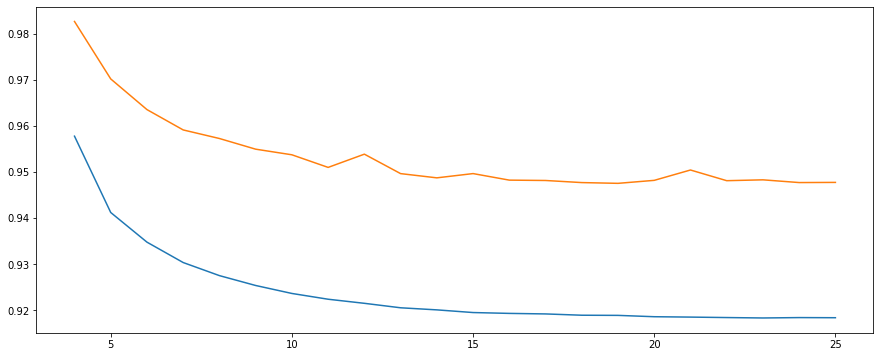

In [72]:
#사용자 별 평균과 아이템별 평균으로 돌렸을 때 MSE가 0.947 정도 나온다
#학습결과 출력
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x=np.arange(4, 26), y=hist_stat.history['loss'][3:])
sns.lineplot(x=np.arange(4, 26), y=hist_stat.history['val_loss'][3:])
plt.show()

In [73]:
# 최소 오차
min(hist_stat.history['val_loss'])

0.9474961757659912

##2.Matrix Factorization

Tensorflow로 Matrix Factorization 구현
가장 기본적인 Matrix Factorization 모델을 사용하여 평점 예측

In [74]:
tf.random.set_seed(1)
input = tf.keras.layers.Input(shape = (2), name='inp')
# Latent Factor 8로 해서 item embedding과 user embedding을 생성
emb_item_l = tf.keras.layers.Embedding(len(df_item) + 1, 8)
emb_user_l = tf.keras.layers.Embedding(len(df_user) + 1, 8)
emb_item = emb_item_l(input[:, 0])
emb_user = emb_user_l(input[:, 1])
# 두개의 embedding의 Dot Product 즉 Factorization 을 수행한다.
prd = tf.keras.layers.Dot(axes=1)([emb_item , emb_user])
model = tf.keras.models.Model(inputs=input, outputs=prd)
model.compile('Adam', tf.keras.losses.mean_squared_error)
# df_base로 모델을 학습시키고, df_test로 검증한다.
hist_mf_simple = model.fit(x=df_base[['item id', 'user id']], y=df_base['rating'], 
                 validation_data=(df_test[['item id', 'user id']], df_test['rating']), epochs=25)

Epoch 1/25
2500/2500 [==============================] - 10s 4ms/step - loss: 10.5449 - val_loss: 5.0006
Epoch 2/25
2500/2500 [==============================] - 10s 4ms/step - loss: 2.2780 - val_loss: 1.7052
Epoch 3/25
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2125 - val_loss: 1.1945
Epoch 4/25
2500/2500 [==============================] - 10s 4ms/step - loss: 0.9991 - val_loss: 1.0384
Epoch 5/25
2500/2500 [==============================] - 10s 4ms/step - loss: 0.9315 - val_loss: 0.9873
Epoch 6/25
2500/2500 [==============================] - 10s 4ms/step - loss: 0.9027 - val_loss: 0.9614
Epoch 7/25
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8893 - val_loss: 0.9492
Epoch 8/25
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8806 - val_loss: 0.9464
Epoch 9/25
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8742 - val_loss: 0.9388
Epoch 10/25
2500/2500 [==============================] - 10s 4ms/step - 

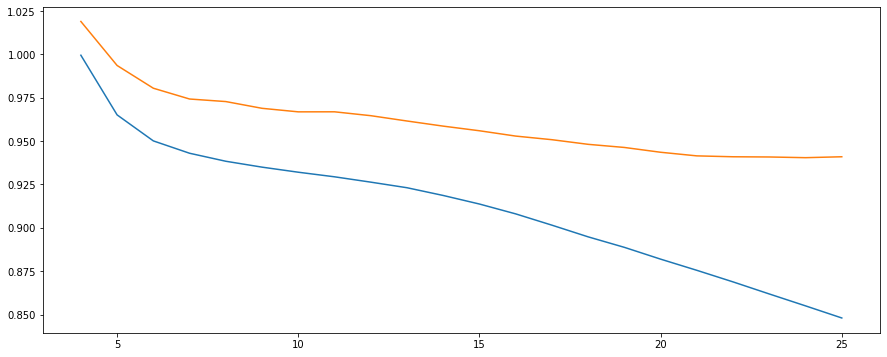

In [75]:
#학습결과 출력
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x=np.arange(4, 26), y=np.sqrt(hist_mf_simple.history['loss'][3:]))
sns.lineplot(x=np.arange(4, 26), y=np.sqrt(hist_mf_simple.history['val_loss'][3:]))
plt.show()

Train에서 loss는 급격히 줄여 가지만, valid set에 대해서는 성능은 점진적으로 수렴해간다.

이후 더 학습을 한다고 해도 valid set에 대한 성능 향상 보다는 overfit이 발생할 것으로 보인다.

In [76]:
# 최소 오차
min(hist_mf_simple.history['val_loss'])

0.8844428658485413

In [77]:
 print('통계적 예측 대비 성능향상 {}%'.format((1 - np.sqrt(min(hist_mf_simple.history['val_loss'])) / np.sqrt(min(hist_stat.history['val_loss']))) * 100))

통계적 예측 대비 성능향상 3.3846439498474434%


#8.Recommenders Model

##1.Gradient Boosted Tree

Gradient Boosted Tree를 구현한 모듈은 XGBoost, LightGBM... 등있지만,

XGBoost가 뛰어난 성능을 보인다고 Kaggle의 여러 사례에서 보여 줬지만, 

이 모듈은  굉장히 무거워서, 여기에서는 비교적 연산부하가 적은 LightGBM을 쓰겠다 

In [78]:
def try_lgb(X, y, eval_set,  verbose=0, **args):
  """
  light gbm 모델을 학습시킨다. 
  또한, eval_set을 통하여 학습 중간에 검증셋에 대한 MSE의 변화를 측정한다.

  Parameters
  ----------
  X: dataframe
    - input data
  y: series
    - target
  eval_set: tuple
    (eval input,eval y) - 검증데이터
  verbose: int
    Training Metric 출력
  
  Returns
  -------
    object, float
      - regressor, Mean Squared error 
  """
  # Light GBM Regressor 생성
  lgbm_c = lgb.LGBMRegressor(**args)
  # Light GBM 학습
  lgbm_c.fit(X, y, eval_set=[(X, y), eval_set], verbose=verbose)
  # 예측
  y = lgbm_c.predict(eval_set[0])
  # mse 계산
  mse = np.mean(np.square(y - eval_set[1]))
  return lgbm_c, mse

In [79]:
cols = ['item id', 'user id', 'date_diff', 'age', 
        'user_rating_mean', 'item_rating_mean', 'user_rating_count', 'item_rating_count'] + genre + occ_cols + post1_cols

In [80]:
df_base,  df_test = read_dataset(1)
lgbm_c, mse = try_lgb(df_base[cols], df_base['rating'], (df_test[cols], df_test['rating']), verbose=5,
        n_estimators=100, learning_rate=0.05, num_leaves=31, colsample_bytree=0.75)

[5]	training's l2: 1.12825	valid_1's l2: 1.20054
[10]	training's l2: 1.04047	valid_1's l2: 1.1088
[15]	training's l2: 0.984906	valid_1's l2: 1.05231
[20]	training's l2: 0.946407	valid_1's l2: 1.01434
[25]	training's l2: 0.915825	valid_1's l2: 0.990288
[30]	training's l2: 0.891444	valid_1's l2: 0.970986
[35]	training's l2: 0.874827	valid_1's l2: 0.961438
[40]	training's l2: 0.858692	valid_1's l2: 0.952985
[45]	training's l2: 0.844187	valid_1's l2: 0.947831
[50]	training's l2: 0.833065	valid_1's l2: 0.944453
[55]	training's l2: 0.821304	valid_1's l2: 0.941871
[60]	training's l2: 0.811614	valid_1's l2: 0.939005
[65]	training's l2: 0.801792	valid_1's l2: 0.937864
[70]	training's l2: 0.7924	valid_1's l2: 0.936805
[75]	training's l2: 0.7834	valid_1's l2: 0.93582
[80]	training's l2: 0.774911	valid_1's l2: 0.936117
[85]	training's l2: 0.767372	valid_1's l2: 0.93585
[90]	training's l2: 0.760065	valid_1's l2: 0.9352
[95]	training's l2: 0.752913	valid_1's l2: 0.934965
[100]	training's l2: 0.74554

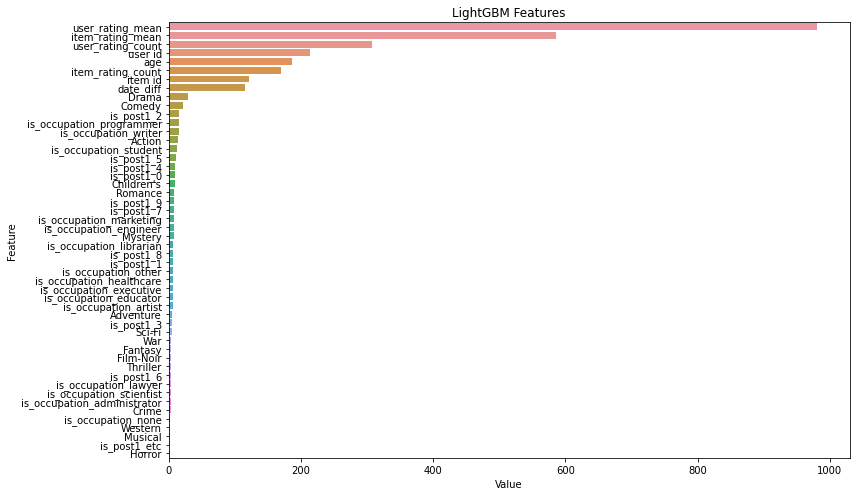

In [81]:
# Feature의 중요성을 출력해 본다
feature_imp = pd.DataFrame(sorted(zip(lgbm_c.feature_importances_, cols))[-50:], columns=['Value','Feature'])
plt.figure(figsize=(12, 7))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

검증셋에 대한 MSE는 0.934 이다.
Sparse하고 다수의 Category (user id, item id) 에 대한 Gradient Boosted Tree의 효과는 크지 않음을 확인할 수 있다. 
즉 Tree 기반의 모델은 적합하지 않다.

##2.Linear Regression

이전 챕터에서 평균값들로 회귀분석한 것을 item id, user id와 다른 feature를 포함하여 모델을 구성했다

In [82]:
# Liner Regression은 categorical feature을 직접 취할 수 없다. one_hot, variable로 치환하고
# 비균등한 feature(item_rating_count, view_rating_count, date_diff) 등은 binning해서 사용한다.
cols = ['item id', 'user id', 'user_rating_mean', 'item_rating_mean']
cols += genre + occ_cols + aged_cols + date_diffd_cols + item_rating_countd_cols + user_rating_countd_cols + post1_cols

In [83]:
def try_lr(X, y, eval_set, 
           learning_rate=0.001, epochs=20, lf_dim_i=8, lf_dim_u=4, l2_i = 0.0, l2_u = 0.0, verbose=1):
  """
  Linear Regression 모델을 학습시키고, 검증한다.
  또한, eval_set을 통하여 학습 중간에 검증셋에 대한 MSE의 변화를 측정한다.
  
  Parameters
  ----------
  X: dataframe
    - input data, 첫번째 항목은 item id 두번째 항목은 user id여야 한다.
  y: series
    - target
  eval_set: tuple
    (eval input,eval y) - 검증데이터
  learning_rate: float
    학습율
  epochs: integer
    학습 Loop 수
  lf_dim_i: integer
    item의 embedding 수
  lf_dim_u: integer
    user의 embedding 수
  l2_i: float
    item embedding의 l2 regularization 계수
  l2_u: float
    user embedding의 l2 regularization 계수
  verbose: int
    Training Metric 출력
  
  Returns
  -------
    object, list, float
      - regressor, 학습 history, Mean Squared error 
  """
  # input layer 생성
  input = tf.keras.layers.Input(shape = (X.shape[1]), name='inp')
  # item id에 대한 Embediing 레이어 생성
  emb_item_l = tf.keras.layers.Embedding(len(df_item) + 1, lf_dim_i, 
                                         embeddings_initializer='zero', embeddings_regularizer = tf.keras.regularizers.L2(l2=l2_i))
  # user id에 대한 Embediing 레이어 생성
  emb_user_l = tf.keras.layers.Embedding(len(df_user) + 1, lf_dim_u, 
                                         embeddings_initializer='zero', embeddings_regularizer = tf.keras.regularizers.L2(l2=l2_u))
  # item embedding에 첫번째 입력 열을 떼어 넣는다, 즉 item id는  입력에 첫번재 열에 있어야 한다.
  emb_item = emb_item_l(input[:, 0])
  # user embedding에 두번째 입력 열을 떼어 넣는다, 즉 user id는  입력에 두번재 열에 있어야 한다.
  emb_user = emb_user_l(input[:, 1])
  # item / user embedding과 나머지 입력을 결합한다.
  c = tf.keras.layers.Concatenate()([emb_item, emb_user, input[:, 2:]])
  # Hidden Unit이 없고 Dense Layer Unit이 1 이면 곧 Linear Regression이 된다.
  prd = tf.keras.layers.Dense(1)(c)
  model = tf.keras.models.Model(inputs=input, outputs=prd)
  model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), tf.keras.losses.mean_squared_error)
  # df_base로 모델을 학습시키고, df_test로 검증한다.
  hist = model.fit(x=X, y=y, validation_data=eval_set, epochs=epochs, verbose=verbose)
  mse = np.mean(np.square(np.hstack(model.predict(eval_set[0])) - eval_set[1]))
  return model, hist, mse

In [84]:
df_base, df_test = read_dataset(1)

In [85]:
tf.random.set_seed(1)
# Parameter 최적화 방법을 따로 쓰지는 않고, 실험을 거듭하면서 가장 좋은 결과를 냈던 learning rate, lf_dim_i, lf_dim_u, l2_i, l2u를 사용
model, hist_lr, mse_lr = try_lr(df_base[cols], df_base['rating'], (df_test[cols], df_test['rating']), 0.001, 20, 8, 4, 0.0, 0.0)

Epoch 1/20
2500/2500 [==============================] - 8s 3ms/step - loss: 1.1503 - val_loss: 0.9217
Epoch 2/20
2500/2500 [==============================] - 7s 3ms/step - loss: 0.8827 - val_loss: 0.9176
Epoch 3/20
2500/2500 [==============================] - 7s 3ms/step - loss: 0.8747 - val_loss: 0.9142
Epoch 4/20
2500/2500 [==============================] - 7s 3ms/step - loss: 0.8701 - val_loss: 0.9110
Epoch 5/20
2500/2500 [==============================] - 7s 3ms/step - loss: 0.8668 - val_loss: 0.9116
Epoch 6/20
2500/2500 [==============================] - 7s 3ms/step - loss: 0.8643 - val_loss: 0.9111
Epoch 7/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.8625 - val_loss: 0.9109
Epoch 8/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.8609 - val_loss: 0.9111
Epoch 9/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.8590 - val_loss: 0.9128
Epoch 10/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.857

##3.Multi-layer Neural Networks

Linear Regression에 Hidden Unit을 붙여 Multi-layer Neural Networks를 붙였다.

In [86]:
# Liner Regression과 마찬가지로 categorical feature을 직접 취할 수 없다. one_hot, variable로 치환하고
# 비균등한 feature(item_rating_count, view_rating_count, date_diff) 등은 binning해서 사용한다.
cols = ['item id', 'user id', 'user_rating_mean', 'item_rating_mean']
cols += genre + occ_cols + aged_cols + date_diffd_cols + item_rating_countd_cols + user_rating_countd_cols + post1_cols

In [87]:
def try_nn(X, y, eval_set, 
           units=[(16, 0.5)], learning_rate=0.001, learning_rate_scheduler=None, 
           epochs=20, lf_dim_i=8, lf_dim_u=4, l2_i = 0.0, l2_u =0.0, verbose=1):
  """
  Neural Network 모델을 학습시키고, 검증한다.
  또한, eval_set을 통하여 학습 중간에 검증셋에 대한 MSE의 변화를 측정한다.
  
  Parameters
  ----------
  X: dataframe
    - input data, 첫번째 항목은 item id 두번째 항목은 user id여야 한다.
  y: series
    - target
  eval_set: tuple
    (eval input,eval y) - 검증데이터
  units: list
    Neural Network의 hidden layer에 대한 (unit의 수 , dropout rate) 
  learning_rate: float
    학습율
  epochs: integer
    학습 Loop 수
  lf_dim_i: integer
    item의 embedding 수
  lf_dim_u: integer
    user의 embedding 수
  l2_i: float
    item embedding의 l2 regularization 계수
  l2_u: float
    user embedding의 l2 regularization 계수
  verbose: int
    Training Metric 출력
  
  Returns
  -------
    object, list, float
      - regressor, 학습 history, Mean Squared error 
  """
  # input layer 생성
  input = tf.keras.layers.Input(shape = (X.shape[1]), name='inp')
  # item id에 대한 Embediing 레이어 생성
  emb_item_l = tf.keras.layers.Embedding(len(df_item) + 1, lf_dim_i, 
                                         embeddings_initializer='zero', embeddings_regularizer = tf.keras.regularizers.L2(l2=l2_i))
  # user id에 대한 Embediing 레이어 생성
  emb_user_l = tf.keras.layers.Embedding(len(df_user) + 1, lf_dim_u, 
                                         embeddings_initializer='zero', embeddings_regularizer = tf.keras.regularizers.L2(l2=l2_u))
  # item embedding에 첫번째 입력 열을 떼어 넣는다, 즉 item id는  입력에 첫번재 열에 있어야 한다.
  emb_item = emb_item_l(input[:, 0])
  # user embedding에 두번째 입력 열을 떼어 넣는다, 즉 user id는  입력에 두번재 열에 있어야 한다.
  emb_user = emb_user_l(input[:, 1])
  # item / user embedding과 나머지 입력을 결합한다.
  c = tf.keras.layers.Concatenate()([emb_item, emb_user, input[:, 2:]])
  # Hidden Layer 구성
  for i, unit in enumerate(units):
    # Hidden Unit이 없고 Dense Layer Unit이 1 이면 곧 Linear Regression이 된다.
    c = tf.keras.layers.Dense(unit[0])(c)
    c = tf.keras.layers.BatchNormalization()(c)
    if unit[1] > 0:
      c = tf.keras.layers.Dropout(unit[1])(c)
    c = tf.keras.layers.ReLU()(c)
  # Logit Layer
  prd = tf.keras.layers.Dense(1)(c)
  model = tf.keras.models.Model(inputs=input, outputs=prd)
  model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), tf.keras.losses.mean_squared_error)
  # Learning rate를 callback을 통해서 epoch가 진행될 때마다 변경할 수 있게 한다.
  if learning_rate_scheduler != None:
    callbacks = [tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)]
  else:
    callbacks = None
  # df_base로 모델을 학습시키고, df_test로 검증한다.
  hist = model.fit(x=X, y=y, validation_data=eval_set, epochs=epochs, verbose=verbose, callbacks=callbacks)
  mse = np.mean(np.square(np.hstack(model.predict(eval_set[0])) - eval_set[1]))
  return model, hist, mse

In [88]:
df_base, df_test = read_dataset(1)

In [89]:
tf.random.set_seed(1)

## Overfit되는 현상을 막기 위해, Learning Rate를 epoch에 따라 낮춰 준다
def decay_nn(epoch):
  if epoch < 10:
    return 1e-3
  elif epoch >= 10 and epoch < 15:
    return 5e-4
  else:
    return 2e-4

# Parameter 최적화 방법을 따로 쓰지는 않고, 실험을 거듭하면서 가장 좋은 결과를 냈던 units, learning rate, lf_dim_i, lf_dim_u, l2_i, l2u를 사용
model, hist_nn, mse_nn = try_nn(df_base[cols], df_base['rating'], (df_test[cols], df_test['rating']),
                    [(64, 0.3), (32, 0.15), (16, 0.0)], 0.001, decay_nn, 20, 8, 4, 0.0, 0.0)

Epoch 1/20
2500/2500 [==============================] - 14s 5ms/step - loss: 1.7721 - val_loss: 0.9530 - lr: 0.0010
Epoch 2/20
2500/2500 [==============================] - 12s 5ms/step - loss: 0.9816 - val_loss: 0.9300 - lr: 0.0010
Epoch 3/20
2500/2500 [==============================] - 14s 5ms/step - loss: 0.9378 - val_loss: 0.9276 - lr: 0.0010
Epoch 4/20
2500/2500 [==============================] - 12s 5ms/step - loss: 0.9125 - val_loss: 0.9083 - lr: 0.0010
Epoch 5/20
2500/2500 [==============================] - 12s 5ms/step - loss: 0.8939 - val_loss: 0.8977 - lr: 0.0010
Epoch 6/20
2500/2500 [==============================] - 13s 5ms/step - loss: 0.8773 - val_loss: 0.8940 - lr: 0.0010
Epoch 7/20
2500/2500 [==============================] - 13s 5ms/step - loss: 0.8652 - val_loss: 0.8892 - lr: 0.0010
Epoch 8/20
2500/2500 [==============================] - 14s 5ms/step - loss: 0.8545 - val_loss: 0.8839 - lr: 0.0010
Epoch 9/20
2500/2500 [==============================] - 13s 5ms/step - l

##4.Multi-layer Matrix Factorization

이전 장의 Matrix Factorization에 다른 input을 붙이고, item과 user를 따로 Hidden Layer로 구성 Factorization을 하여 Multi-layer Matrix Factorization을 구성했다.

In [90]:
def try_mf(Xi, Xu, y, eval_set, 
           units_i=[(4, 0.5)], units_u=[(4, 0.5)], learning_rate=0.001, learning_rate_scheduler=None, 
           epochs=20, lf_dim_i=8, lf_dim_u=4, l2_i=0.0, l2_u=0.0, verbose=1):
  """
  Multi Layer Matrix Factorization 모델을 학습시키고, 검증한다.
  또한, eval_set을 통하여 학습 중간에 검증셋에 대한 MSE의 변화를 측정한다.
  Matrix Factorization의 입력은 item과 user 둘로 나뉜다.
  Parameters
  ----------
  Xi: dataframe
    - item input data, 첫번째 항목은 item id 
  Xu: dataframe
    - user input data, 첫번째 항목은 user id여야 한다.
  y: series
    - target
  eval_set: tuple
    (eval item input, eval user input,eval y) - 검증데이터
  units_i: list
    item Neural Network의 hidden layer에 대한 (unit의 수 , dropout rate) 
  units_u: list
    user Neural Network의 hidden layer에 대한 (unit의 수 , dropout rate) 
  learning_rate: float
    학습율
  epochs: integer
    학습 Loop 수
  lf_dim_i: integer
    item의 embedding 수
  lf_dim_u: integer
    user의 embedding 수
  l2_i: float
    item embedding의 l2 regularization 계수
  l2_u: float
    user embedding의 l2 regularization 계수
  verbose: int
    Training Metric 출력
  
  Returns
  -------
    object, list, float
      - regressor, 학습 history, Mean Squared error 
  """
  # item input layer 생성
  input_i = tf.keras.layers.Input(shape = (Xi.shape[1]), name='inp_i')
  # user input layer 생성
  input_u = tf.keras.layers.Input(shape = (Xu.shape[1]), name='inp_u')
  # item id에 대한 Embediing 레이어 생성
  emb_item_l = tf.keras.layers.Embedding(len(df_item) + 1, lf_dim_i, 
                                         embeddings_initializer='zero', embeddings_regularizer = tf.keras.regularizers.L2(l2=l2_i))
  # user id에 대한 Embediing 레이어 생성
  emb_user_l = tf.keras.layers.Embedding(len(df_user) + 1, lf_dim_u, 
                                         embeddings_initializer='zero', embeddings_regularizer = tf.keras.regularizers.L2(l2=l2_u))
  # item embedding에 첫번째 입력 열을 떼어 넣는다, 즉 item id는  입력에 첫번재 열에 있어야 한다.
  emb_item = emb_item_l(input_i[:, 0])
  # user embedding에 첫번째 입력 열을 떼어 넣는다, 즉 user id는  입력에 첫번재 열에 있어야 한다.
  emb_user = emb_user_l(input_u[:, 0])

  # item embedding을 item input의 나머지 feature와 결합
  ci = tf.keras.layers.Concatenate()([emb_item, input_i[:, 1:]])
  #  item의 hidden layer 구성
  for i, unit in enumerate(units_i):
    ci = tf.keras.layers.Dense(unit[0])(ci)
    ci = tf.keras.layers.BatchNormalization()(ci)
    if unit[1] > 0:
      ci = tf.keras.layers.Dropout(unit[1])(ci)
    ci = tf.keras.layers.ReLU()(ci)
  
  # user embedding을 item input의 나머지 feature와 결합
  #  user의 hidden layer 구성
  cu = tf.keras.layers.Concatenate()([emb_user, input_u[:, 1:]])
  for i, unit in enumerate(units_u):
    cu = tf.keras.layers.Dense(unit[0])(cu)
    cu = tf.keras.layers.BatchNormalization()(cu)
    if unit[1] > 0:
      cu = tf.keras.layers.Dropout(unit[1])(cu)
    cu = tf.keras.layers.ReLU()(cu)
  # Factorization
  prd = tf.keras.layers.Dot(axes=1)([ci , cu])
  model = tf.keras.models.Model(inputs=[input_i, input_u], outputs=prd)
  model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), tf.keras.losses.mean_squared_error)
  # Learning rate를 callback을 통해서 epoch가 진행될 때마다 변경할 수 있게 한다.
  if learning_rate_scheduler != None:
    callbacks = [tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)]
  else:
    callbacks = None
  # df_base로 모델을 학습시키고, df_test로 검증한다.
  hist = model.fit(x=(Xi, Xu), y=y, validation_data=eval_set, epochs=epochs, verbose=verbose, callbacks=callbacks)
  mse = np.mean(np.square(np.hstack(model.predict(eval_set[0])) - eval_set[1]))
  return model, hist, mse

In [91]:
# Item input에서 사용할 컬럼
cols_i = ['item id', 'item_rating_mean']
# user input에서 사용할 컬럼
cols_u = ['user id', 'user_rating_mean']
cols_i += genre + item_rating_countd_cols
cols_u += occ_cols + aged_cols + date_diffd_cols + post1_cols

In [92]:
df_base, df_test = read_dataset(1)

In [93]:
tf.random.set_seed(1)

## Overfit되는 현상을 막기 위해, Learning Rate를 epoch에 따라 낮춰 준다
def decay_mf(epoch):
  if epoch < 5:
    return 1e-3
  elif epoch >= 5 and epoch < 10:
    return 5e-4
  else:
    return 2e-4

# Parameter 최적화 방법을 따로 쓰지는 않고, 실험을 거듭하면서 가장 좋은 결과를 냈던 units_i, units_u, learning rate, lf_dim_i, lf_dim_u, l2_i, l2_u를 사용
model, hist_mf, mse_mf = try_mf(df_base[cols_i], df_base[cols_u], df_base['rating'], 
                    ((df_test[cols_i], df_test[cols_u]), df_test['rating']),[(64, 0.5), (32, 0.05)],[(32, 0.05)], 0.001, decay_mf, 20, 8, 4)

Epoch 1/20
2500/2500 [==============================] - 16s 6ms/step - loss: 2.6929 - val_loss: 1.4383 - lr: 0.0010
Epoch 2/20
2500/2500 [==============================] - 13s 5ms/step - loss: 1.3467 - val_loss: 1.0037 - lr: 0.0010
Epoch 3/20
2500/2500 [==============================] - 13s 5ms/step - loss: 1.0892 - val_loss: 0.9249 - lr: 0.0010
Epoch 4/20
2500/2500 [==============================] - 13s 5ms/step - loss: 1.0112 - val_loss: 0.9074 - lr: 0.0010
Epoch 5/20
2500/2500 [==============================] - 13s 5ms/step - loss: 0.9690 - val_loss: 0.9035 - lr: 0.0010
Epoch 6/20
2500/2500 [==============================] - 13s 5ms/step - loss: 0.9374 - val_loss: 0.8845 - lr: 5.0000e-04
Epoch 7/20
2500/2500 [==============================] - 13s 5ms/step - loss: 0.9244 - val_loss: 0.8802 - lr: 5.0000e-04
Epoch 8/20
2500/2500 [==============================] - 14s 6ms/step - loss: 0.9168 - val_loss: 0.8750 - lr: 5.0000e-04
Epoch 9/20
2500/2500 [==============================] - 14s 

##5.Multi-layer Factorization Networks

Matrix Factorization과 Neural Network를 결합한 모델

In [94]:
def try_fnn(Xi, Xu, y, eval_set, 
           units_i=[(4, 0.5)], units_u=[(4, 0.5)], units=[(1, 0.0)], learning_rate=0.001, learning_rate_scheduler=None, 
           epochs=20, lf_dim_i=8, lf_dim_u=4, l2_i=0.0, l2_u=0.0, verbose=1):
  """
  Multi Layer Matrix Factorization 모델을 학습시키고, 검증한다.
  또한, eval_set을 통하여 학습 중간에 검증셋에 대한 MSE의 변화를 측정한다.
  Matrix Factorization의 입력은 item과 user 둘로 나뉜다.
  Parameters
  ----------
  Xi: dataframe
    - item input data, 첫번째 항목은 item id 
  Xu: dataframe
    - user input data, 첫번째 항목은 user id여야 한다.
  y: series
    - target
  eval_set: tuple
    (eval item input, eval user input,eval y) - 검증데이터
  units_i: list
    item Neural Network의 hidden layer에 대한 (unit의 수 , dropout rate) 
  units_u: list
    user Neural Network의 hidden layer에 대한 (unit의 수 , dropout rate) 
  learning_rate: float
    학습율
  epochs: integer
    학습 Loop 수
  lf_dim_i: integer
    item의 embedding 수
  lf_dim_u: integer
    user의 embedding 수
  l2_i: float
    item embedding의 l2 regularization 계수
  l2_u: float
    user embedding의 l2 regularization 계수
  verbose: int
    Training Metric 출력
  
  Returns
  -------
    object, list, float
      - regressor, 학습 history, Mean Squared error 
  """
  # item input layer 생성
  input_i = tf.keras.layers.Input(shape = (Xi.shape[1]), name='inp_i')
  # user input layer 생성
  input_u = tf.keras.layers.Input(shape = (Xu.shape[1]), name='inp_u')
  # item id에 대한 Embediing 레이어 생성
  emb_item_l = tf.keras.layers.Embedding(len(df_item) + 1, lf_dim_i, 
                                         embeddings_initializer='zero', embeddings_regularizer = tf.keras.regularizers.L2(l2=l2_i))
  # user id에 대한 Embediing 레이어 생성
  emb_user_l = tf.keras.layers.Embedding(len(df_user) + 1, lf_dim_u, 
                                         embeddings_initializer='zero', embeddings_regularizer = tf.keras.regularizers.L2(l2=l2_u))
  # item embedding에 첫번째 입력 열을 떼어 넣는다, 즉 item id는  입력에 첫번재 열에 있어야 한다.
  emb_item = emb_item_l(input_i[:, 0])
  # user embedding에 첫번째 입력 열을 떼어 넣는다, 즉 user id는  입력에 첫번재 열에 있어야 한다.
  emb_user = emb_user_l(input_u[:, 0])

  # item embedding을 item input의 나머지 feature와 결합
  ci = tf.keras.layers.Concatenate()([emb_item, input_i[:, 1:]])
  #  item의 hidden layer 구성
  for i, unit in enumerate(units_i):
    ci = tf.keras.layers.Dense(unit[0])(ci)
    ci = tf.keras.layers.BatchNormalization()(ci)
    if unit[1] > 0:
      ci = tf.keras.layers.Dropout(unit[1])(ci)
    ci = tf.keras.layers.ReLU()(ci)
  
  # user embedding을 item input의 나머지 feature와 결합
  #  user의 hidden layer 구성
  cu = tf.keras.layers.Concatenate()([emb_user, input_u[:, 1:]])
  for i, unit in enumerate(units_u):
    cu = tf.keras.layers.Dense(unit[0])(cu)
    cu = tf.keras.layers.BatchNormalization()(cu)
    if unit[1] > 0:
      cu = tf.keras.layers.Dropout(unit[1])(cu)
    cu = tf.keras.layers.ReLU()(cu)
  # Factorization
  c = tf.keras.layers.Multiply()([ci , cu])
  for i, unit in enumerate(units):
    c = tf.keras.layers.Dense(unit[0])(c)
    c = tf.keras.layers.BatchNormalization()(c)
    if unit[1] > 0:
      c = tf.keras.layers.Dropout(unit[1])(c)
    c = tf.keras.layers.ReLU()(c)
  prd = tf.keras.layers.Dense(units=1)(c)
  model = tf.keras.models.Model(inputs=[input_i, input_u], outputs=prd)
  model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), tf.keras.losses.mean_squared_error)
  # Learning rate를 callback을 통해서 epoch가 진행될 때마다 변경할 수 있게 한다.
  if learning_rate_scheduler != None:
    callbacks = [tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)]
  else:
    callbacks = None
  # df_base로 모델을 학습시키고, df_test로 검증한다.
  hist = model.fit(x=(Xi, Xu), y=y, validation_data=eval_set, epochs=epochs, verbose=verbose, callbacks=callbacks)
  mse = np.mean(np.square(np.hstack(model.predict(eval_set[0])) - eval_set[1]))
  return model, hist, mse

In [95]:
# Item input에서 사용할 컬럼
cols_i = ['item id', 'item_rating_mean']
# user input에서 사용할 컬럼
cols_u = ['user id', 'user_rating_mean']
cols_i += genre + item_rating_countd_cols
cols_u += occ_cols + aged_cols + date_diffd_cols + post1_cols

In [96]:
df_base, df_test = read_dataset(1)

In [97]:
tf.random.set_seed(1)


# Parameter 최적화 방법을 따로 쓰지는 않고, 실험을 거듭하면서 가장 좋은 결과를 냈던 units_i, units_u, learning rate, lf_dim_i, lf_dim_u, l2_i, l2_u를 사용
model, hist_fnn, mse_fnn = try_fnn(df_base[cols_i], df_base[cols_u], df_base['rating'], 
                    ((df_test[cols_i], df_test[cols_u]), df_test['rating']),[(64, 0.5), (32, 0.05)],[(32, 0.05)], [(16, 0.0)], 0.001, None, 20, 8, 4)

Epoch 1/20
2500/2500 [==============================] - 16s 6ms/step - loss: 2.2107 - val_loss: 1.0152
Epoch 2/20
2500/2500 [==============================] - 15s 6ms/step - loss: 1.0228 - val_loss: 0.9650
Epoch 3/20
2500/2500 [==============================] - 16s 6ms/step - loss: 0.9594 - val_loss: 0.9399
Epoch 4/20
2500/2500 [==============================] - 15s 6ms/step - loss: 0.9276 - val_loss: 0.9205
Epoch 5/20
2500/2500 [==============================] - 16s 6ms/step - loss: 0.9056 - val_loss: 0.9095
Epoch 6/20
2500/2500 [==============================] - 14s 6ms/step - loss: 0.8878 - val_loss: 0.8968
Epoch 7/20
2500/2500 [==============================] - 16s 6ms/step - loss: 0.8738 - val_loss: 0.8919
Epoch 8/20
2500/2500 [==============================] - 16s 6ms/step - loss: 0.8645 - val_loss: 0.8847
Epoch 9/20
2500/2500 [==============================] - 14s 6ms/step - loss: 0.8549 - val_loss: 0.8841
Epoch 10/20
2500/2500 [==============================] - 16s 6ms/step - l

##6.결과 분석

In [98]:
df_loss = pd.DataFrame({'epoch': np.arange(2, 21), 'Linear Regression': np.sqrt(hist_lr.history['val_loss'][1:]),
                        'Mult-Layer Neural Networks': np.sqrt(hist_nn.history['val_loss'][1:]),
                        'Mult-Layer Matrix Factorization': np.sqrt(hist_mf.history['val_loss'][1:]),
                        'Mult-Layer Factorization Network': np.sqrt(hist_fnn.history['val_loss'][1:])})

In [99]:
df_loss = pd.melt(df_loss, id_vars=['epoch'], 
                  value_vars=['Linear Regression', 'Mult-Layer Neural Networks', 'Mult-Layer Matrix Factorization', 'Mult-Layer Factorization Network'], value_name='RMSE')
df_loss.columns=['epoch', 'Model', 'RMSE']

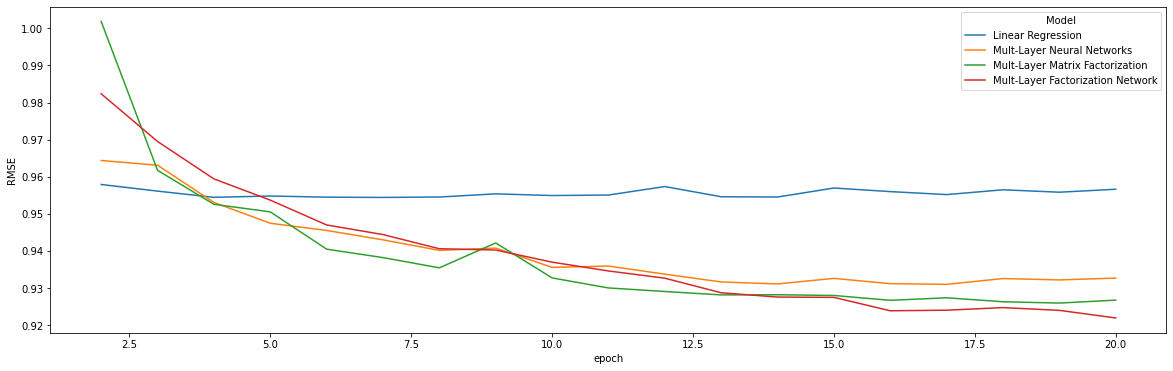

In [100]:
# 시청한 장르수
fig, ax = plt.subplots(figsize=(20, 6))
sns.lineplot(x='epoch', y='RMSE', hue='Model', data=df_loss, ax=ax)
plt.show()

Linear Regression은 epoch epoch가 지남에 따라 유의미한 성능 개선을 보이지 못했다.

Multi-layer Neural Networks와 Multi-layer Matrix Factorization 안정적인 Training을 위해서 Learning Rate Decay가 필요했다. 

반면 Multi-Layer Factorization Network는 따로 Learning Rate Decay가 필요 없었다.

Mutli-Layer Neural Networks보다 Multi-Layer Matrix Factorization이 RMSE가 보다 낮았고

미세하게 나마 Multi-Layer Matrix Factorization 보다 Multi-Layer Factorization Networks가 성능이 좋았다.


가장 RMSE가 낮았던 epoch의 수치

In [101]:
pd.DataFrame({'Model': ['Linear Regression', 
                        'Mult-Layer Neural Networks', 
                        'Mult-Layer Matrix Factorization', 
                        'Mult-Layer Factorization Network'], 
              'RMSE': [np.sqrt(np.min(hist_lr.history['val_loss'])), 
                       np.sqrt(np.min(hist_nn.history['val_loss'])), 
                       np.sqrt(np.min(hist_mf.history['val_loss'])), 
                       np.sqrt(np.min(hist_fnn.history['val_loss']))]})

,Model,RMSE
0,Linear Regression,0.954420
1,Mult-Layer Neural Networks,0.930985
2,Mult-Layer Matrix Factorization,0.925937
3,Mult-Layer Factorization Network,0.921920


##7.5-Fold CrossValidation에 대한 결과

In [102]:
cross_valid_result ={'Linear Regression': [], 
                     'Mult-Layer Neural Networks': [], 
                     'Mult-Layer Matrix Factorization': [],
                     'Mult-Layer Factorization Network': []}
for i in range(1, 6):
  print('Dataset no: {}'.format(i))
  df_base,  df_test = read_dataset(i)
  tf.random.set_seed(1)
  # Parameter 최적화 방법을 따로 쓰지는 않고, 실험을 거듭하면서 가장 좋은 결과를 냈던 learning rate, lf_dim_i, lf_dim_u, l2_i, l2u를 사용
  model, hist_lr, mse_lr = try_lr(df_base[cols], df_base['rating'], (df_test[cols], df_test['rating']), 0.001, 20, 8, 4, 0.0, 0.0, verbose=0)
  cross_valid_result['Linear Regression'].append(np.sqrt(np.min(hist_lr.history['val_loss'])))
  tf.random.set_seed(1)
  model, hist_nn, mse_nn = try_nn(df_base[cols], df_base['rating'], (df_test[cols], df_test['rating']),
                    [(64, 0.3), (32, 0.15), (16, 0.0)], 0.001, decay_nn, 20, 8, 4, 0.0, 0.0, verbose=0)
  cross_valid_result['Mult-Layer Neural Networks'].append(np.sqrt(np.min(hist_nn.history['val_loss'])))
  tf.random.set_seed(1)
  model, hist_mf, mse_mf = try_mf(df_base[cols_i], df_base[cols_u], df_base['rating'], 
                    ((df_test[cols_i], df_test[cols_u]), df_test['rating']),[(64, 0.5), (32, 0.05)],[(32, 0.05)], 0.001, decay_mf, 20, 8, 4, verbose=0)
  cross_valid_result['Mult-Layer Matrix Factorization'].append(np.sqrt(np.min(hist_mf.history['val_loss'])))
  tf.random.set_seed(1)
  model, hist_fnn, mse_fnn = try_fnn(df_base[cols_i], df_base[cols_u], df_base['rating'], 
                    ((df_test[cols_i], df_test[cols_u]), df_test['rating']),[(64, 0.5), (32, 0.05)],[(32, 0.05)], [(16, 0.0)], 0.001, None, 20, 8, 4, verbose=0)
  cross_valid_result['Mult-Layer Factorization Network'].append(np.sqrt(np.min(hist_fnn.history['val_loss'])))

Dataset no: 1
Dataset no: 2
Dataset no: 3
Dataset no: 4
Dataset no: 5


In [103]:
df_cross_valid = pd.DataFrame(cross_valid_result)

In [104]:
#5-fold cross-validation에 대한 RMSE 비교
df_cross_valid

,Linear Regression,Mult-Layer Neural Networks,Mult-Layer Matrix Factorization,Mult-Layer Factorization Network
0,0.954420,0.931075,0.925890,0.923674
1,0.943692,0.923151,0.916699,0.916352
2,0.939252,0.915580,0.914651,0.912594
3,0.938583,0.918353,0.914604,0.913059
4,0.937976,0.916035,0.910815,0.913927


In [105]:
df_cross_valid.mean()

Linear Regression                   0.942785
Mult-Layer Neural Networks          0.920839
Mult-Layer Matrix Factorization     0.916532
Mult-Layer Factorization Network    0.915921
dtype: float64